# Introduction
This notebook generates the figures for the paper: Sensitivity Analysis of Biochemical Systems Using
Bond Graphs. The companion notebook Sensitivity_PPP.ipynb  contains the Pentose Phosphate Pathway example.

# Supporting software

## Import packages

In [1]:
## Some useful imports
import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import control as con
import copy
import importlib

## For reimporting: use imp.reload(module)
import importlib as imp

## Stoichiometric analysis
import stoich as st

## SVG
import svgBondGraph as sbg

## Stoichiometry to BG
import stoichBondGraph as stbg

## Modularity
# import modular as bgm

## Sloppy parameters
import sloppy as slp

## Display (eg disp.SVG(), disp.
import IPython.display as disp

##
quiet = True
Plotting = False
Titles = not Plotting
grid = False

fontsize=20

## Normalisation
Normalise = True

Warning - scikit.odes not found. Simulations are disabled.


## Transfer function properties

In [2]:
def tfProps(tf,method='truncate'):
    
    ## Steady-state gain 
    g = con.dcgain(tf)
    
    if not con.issiso(tf):
        g = g[0][0]
    
    ## Time constant
    ## Check if direct link
    direct_link = np.any(tf.D)
    ## Only set tau=0 if siso
    if direct_link and con.issiso(tf):
        ## Instant response
        tau = 0
    else:       
        ## Reduce to first-order to estimate time constant
        ## Note that method='matchdc' can give a kernel crash - use 'truncate'
        tf1  = con.balred(sys,orders=1,method=method)
        poles = con.poles(tf1)
        realPoles = np.real(poles)
        tau = -1/min(realPoles)
        
    return g,tau

## Plotting and printing

In [3]:
## Optional plotting
def Savefig(name):
    if Plotting:
        plt.rcParams.update({'font.size': fontsize})
        plt.tight_layout()
        plotname = 'Figs/'+name+'.pdf'
        print('Saving',plotname)
        plt.savefig(plotname)

In [4]:
def latex(m,name):
    lm = sp.latex(sp.Matrix(m),mat_delim="(")
    return name+' &= '+lm

## Optional print latex for the paper
printing = True
def printLatex(s,sc=None):
    if printing:
        ## System properties in LaTeX
        AA = Sys.A; print(latex(AA,'A'))
        BB = Sys.B; print(latex(BB,'B'))
        CC = Sys.C; print(latex(CC,'C'))
        DD = Sys.D; print(latex(DD,'D'))


        for m in ['species','reaction','Nf','Nr','N']:
            print(st.sprintl(s,m))

        if not (sc==None):
            print('%% Nc matrix')
            print(st.sprintl(sc,'N'))

        print(st.sprintrl(s,all=True,chemformula=True))
        print(st.sprintvl(s))

## Steady-state by simulation

In [5]:
## Steady-state by simulation
def SteadyState(s,sc,sf=None,parameter={},X0=None,t_ss=1000):
    t = np.linspace(0,t_ss)
    dat = st.sim(s,sc=sc,sf=sf,t=t,parameter=parameter,X0=X0,tol=1e-4,quiet=quiet)
    X_ss = dat['X'][-1]
    V_ss = dat['V'][-1]
    #dX_ss = sc['N']@V_ss
    dX_ss = dat['dX'][-1]
    dXc_ss = dat['dXc'][-1]
    print(f'Steady-state finder error: {np.linalg.norm(dXc_ss):.2e}')
    return X_ss,V_ss


## Stoichiometry

In [6]:
def Stoichiometry(model,chemostats=[],flowstats=[],CommonSpecies=None,sensitivity=False):
    
    ## Stoichiometry
    s = st.stoich(model,quiet=quiet)

    ## Unify species
    if not (CommonSpecies is None):
        commonSpecies = st.merge(s,CommonSpecies=CommonSpecies)
#         print(commonSpecies)
        st.unify(s,commonSpecies=commonSpecies)
        
    ## Sensitivity
    if sensitivity:
        extra = st.stoichSensitivity(s)
    else:
        extra = []
    
#     print(chemostats+extra)

    ## Chemostats and flowstats
    sc = st.statify(s,chemostats=chemostats+extra)
    sf = st.statify(s,flowstats=flowstats)
        
    return s,sc,sf

## Linearisation

In [7]:
def Linear(s,sc,sf=None,parameter={},X0=None, invar='X', outvar = 'V', quiet=False):
    
    ## Steady state
    if X0 is None:
        X0 = np.ones(s['n_X'])
#     print(len(X0))

    X_ss,V_ss = SteadyState(s,sc,sf=sf,parameter=parameter,X0=X0)
    dX_ss = s['N']@V_ss
    print('X_ss =',X_ss)
    print('V_ss =', V_ss)
#     print('dX_ss =', dX_ss)
        
    ## Linearise
    sys = st.lin(s,sc,sf=sf,x_ss=X_ss,parameter=parameter,
                 invar=invar,outvar=outvar,quiet=quiet)
    
    return sys,X_ss,V_ss,dX_ss
  


In [8]:
def linStep(sc,sys,T=None,X0=None):
    """ Linearised response: step (X0 is None) or initial conditions (otherwise)
    """
    
    if X0 is None:
        resp = con.step_response(sys,T)
        y = resp.y[:,0,:].T
    else:
        L_xX = sc['L_xX']
        G_X = sc['G_X']
        resp = con.initial_response(sys,T,X0=L_xX@X0)
        y = resp.y.T
        
        
    return y

## Extract subsystem from linear system

In [9]:
def Index(A,a):
    
    I = []
    for aa in a:
        i = A.index(aa)
        I.append(i)
    return np.array(I)
        
def zapSmall(x,tol=1e-10,quiet=True):
    
    xx = np.zeros(len(x))
    for i,val in enumerate(x):
        if abs(val)>tol:
            xx[i] = x[i]
        else:
            if not quiet:
                print(f'Setting {i}th coefficient {val:.2} to zero')
    return xx

def extractSubsystem(SYS,sc,sf,inp,outp,minreal=False,tol=None,order=None,quiet=False):
    
    Sys = copy.copy(SYS)
    chemostats = sc['chemostats']
    if sf is None:
        flowstats = []
    else:
        flowstats = sf['flowstats']
    species = sc['species']
    reaction = sc['reaction']
    
    ## Index of input and output
    if inp[0] in chemostats:
        i_inp = Index(chemostats,inp)
#         print('Input:',i_inp,chemostats[i_inp[0]])
    else:
        i_inp = Index(flowstats,inp)+len(chemostats)
        
#     print(i_inp)
    
    if outp[0] in chemostats:
        i_outp = Index(chemostats,outp)
    elif outp[0] in species:
        i_outp = Index(species,outp)
    else:
        if outp[0] in reaction:
            i_outp = Index(reaction,outp)
        else:
            print(f'Output {outp} does not exist')
 
    ## Extract tf
    n_y = len(i_outp)
    n_u = len(i_inp)
    nn = Sys.A.shape
    n_x = nn[0]
#     print(n_x)
    
    sys = con.ss(Sys.A,
                 Sys.B[:,i_inp].reshape(n_x,n_u),
                 Sys.C[i_outp,:].reshape(n_y,n_x),
                 Sys.D[i_outp][:,i_inp].reshape(n_y,n_u))
    if minreal:
        sys = con.minreal(sys,tol=tol,verbose=False)
    
    ## Reduce order
    if not (order is None):
        sys = con.balred(sys,order,method='matchdc')
    
    return sys

## Plotting

In [10]:
def plotSensitivity(dat,reactions=['r1','r2'],plotSim=True,name=None,grid=False):
    ## Folt
    plt.rcParams.update({'font.size': fontsize})
    if plotSim:
        plt.plot(t,y_lin,color='black',lw=3)
    else:
        plt.plot(t,y_lin,label=label,lw=3)  
        
    for reac in reactions:
        i = s['reaction'].index(reac)
        if plotSim:
            label = reac + r' ($\tilde\lambda$ = ' + f'{lam-1:0.2f})'
            pc = int(round(100*(lam-1)))
            label = f'{reac} ({pc}%)'
            plt.plot(t,(dat['V'][:,i]-V_ss[i])/(lam-1),
                     lw=5,ls='dashed',label=label)

    if grid:        
        plt.grid()
    plt.legend()
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\Delta {v}/\Delta{\lambda}$')
#     plt.tight_layout()
    

In [11]:
def plotLines(lw=4,ls='dotted'):
        plt.hlines(g,min(t),max(t),color='black',ls=ls,lw=lw)
        plt.vlines(tau,min(y_lin.flatten()),max(y_lin.flatten()),color='black',ls=ls,lw=lw)

## Normalisation constants

In [12]:
T_human = 37 # Human body temperature
K_0 = 273.15
print(f'T_human = {T_human} degC = {T_human+K_0} K')

mu_0 = RT = st.RT(T_cent=T_human)
print(f'mu_0 = {mu_0*1e-3:0.3f} kJ/mol')

F = st.F() # Faraday's constant
print(f'F = {F*1e-3:0.2f} kC/mol')

V_0 = RT/F
print(f'V_0 = {V_0*1e3:0.2f} mV')

P_0 = 1e-3

v_0 = P_0/mu_0
print(f'v_0 = {v_0*1e6:0.4f} micro mol /s')

i_0 = F*v_0
print(f'i_0 = {i_0*1e3:0.2f} mA')

T_human = 37 degC = 310.15 K
mu_0 = 2.579 kJ/mol
F = 96.49 kC/mol
V_0 = 26.73 mV
v_0 = 0.3878 micro mol /s
i_0 = 37.42 mA


# Simple example A = B = C revisited.
## Bond Graph

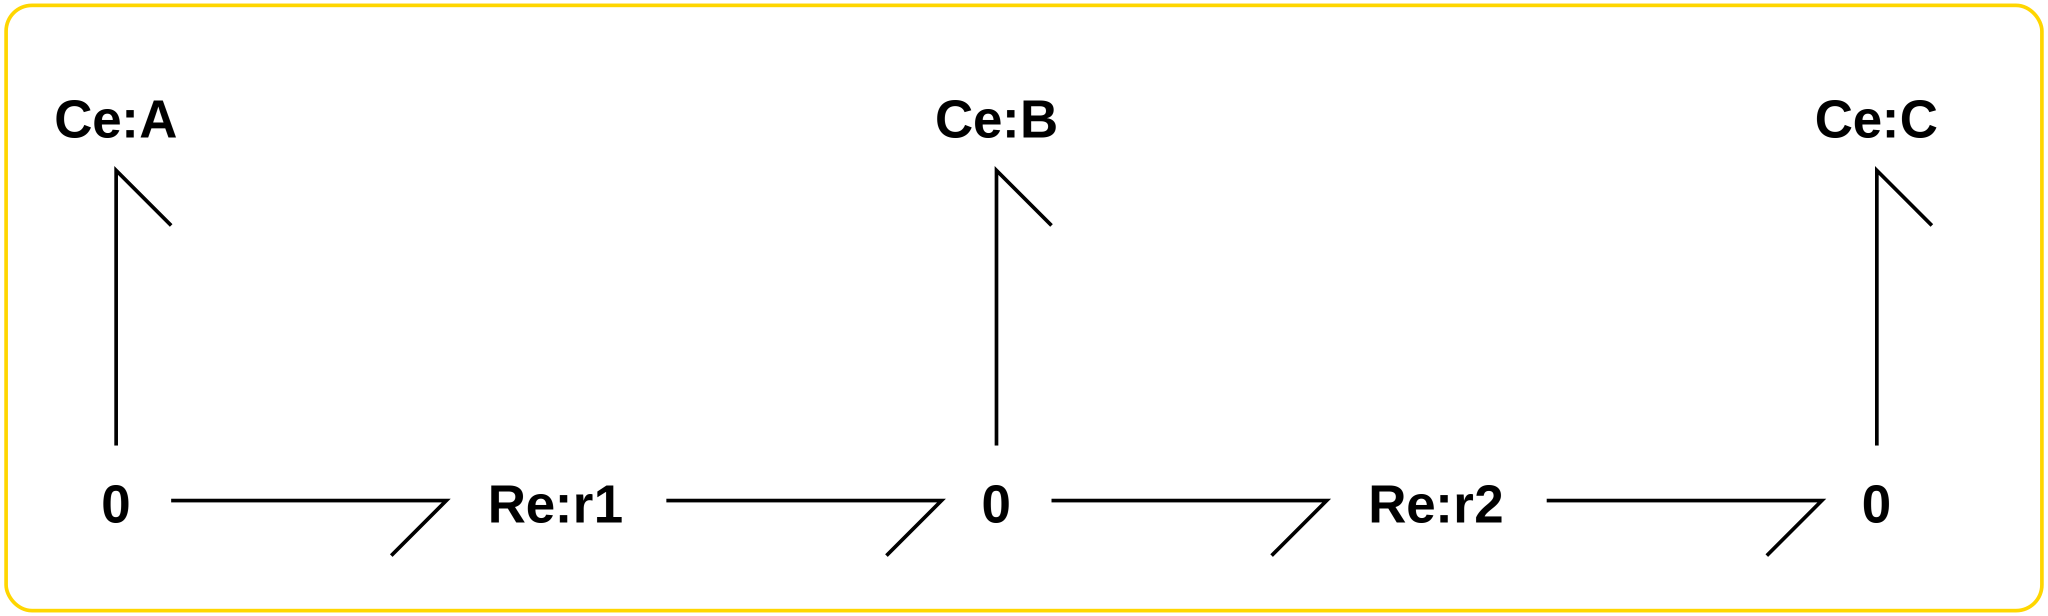

In [13]:
# Simple example A = B = C
sbg.model('ABC_abg.svg')
import ABC_abg
disp.SVG('ABC_abg.svg')

In [14]:
## BG generated equations
# model = ABC_abg.model()
# for cr in model.constitutive_relations:
#     print(cr)
#     #print(sp.diff(cr,'x_0'))


## Parameters

In [15]:
## Parameters
parameter = {}
parameter['K_A'] = 1
parameter['K_B'] = 1
parameter['kappa_r1'] = 1
parameter['kappa_r2'] = 9
print(parameter)

## Initial states
X_A_0 = 2

{'K_A': 1, 'K_B': 1, 'kappa_r1': 1, 'kappa_r2': 9}


## Stoichiometry & linearisation

In [16]:
## Stoichiometry
s,sc,sf = Stoichiometry(ABC_abg.model(),chemostats=['A','C'],flowstats=[])

In [17]:
## Linearise
Parameter = copy.copy(parameter)
Parameter['K_A'] = X_A_0*parameter['K_A']
Sys,X_ss,V_ss,dX_ss = Linear(s,sc,parameter=parameter,X0=[X_A_0,1,1],quiet=quiet)
i_A = s['species'].index('A')
X_A_ss = X_ss[i_A]


## Show transfer function
con.tf(Sys)

## Lambda for comparison
lam = 1.1

Steady-state finder error: 8.88e-16
X_ss = [2.  1.1 1. ]
V_ss = [0.9 0.9]


In [18]:
printLatex(s,sc=sc)

A &= \left(\begin{matrix}-10.0\end{matrix}\right)
B &= \left(\begin{matrix}1.0 & 9.0\end{matrix}\right)
C &= \left(\begin{matrix}-1.0\\9.0\end{matrix}\right)
D &= \left(\begin{matrix}1.0 & 0\\0 & -9.0\end{matrix}\right)
\begin{align}
X&= \begin{pmatrix}
    X_{A}\\
    X_{B}\\
    X_{C}\\
\end{pmatrix}
\end{align}

\begin{align}
V&= \begin{pmatrix}
    V_{r1}\\
    V_{r2}\\
\end{pmatrix}
\end{align}

\begin{align}
Nf &=
\left(\begin{matrix}1 & 0\\0 & 1\\0 & 0\end{matrix}\right)
\end{align}

\begin{align}
Nr &=
\left(\begin{matrix}0 & 0\\1 & 0\\0 & 1\end{matrix}\right)
\end{align}

\begin{align}
N &=
\left(\begin{matrix}-1 & 0\\1 & -1\\0 & 1\end{matrix}\right)
\end{align}

%% Nc matrix
\begin{align}
N &=
\left(\begin{matrix}0 & 0\\1 & -1\\0 & 0\end{matrix}\right)
\end{align}

\begin{align}
\ch{A & <> [ r1 ] B }\\
\ch{B & <> [ r2 ] C }
\end{align}

\begin{align}
v_{r1} &= \kappa_{r1} \left(K_{A} x_{A} - K_{B} x_{B}\right)\\
v_{r2} &= \kappa_{r2} \left(K_{B} x_{B} - K_{C} x_{C}\right)
\en

In [19]:
## Show dc gain
print('DC gain: \n', con.dcgain(Sys))

DC gain: 
 [[ 0.9 -0.9]
 [ 0.9 -0.9]]



## Sensitivity Bond Graph -- change chemostats

In [20]:
## Extract sensitivity system
inp = ['A']
outp = ['r1','r2']
sys = extractSubsystem(Sys,sc,sf,inp,outp)

## Include factor X_A_0 into the linarised system
sys.B = sys.B*X_A_0
sys.D = sys.D*X_A_0

In [21]:
## Show transfer function
con.tf(sys)


TransferFunction([[array([ 2., 18.])], [array([18.])]], [[array([ 1., 10.])], [array([ 1., 10.])]])

In [22]:
## System matrix
sys

<LinearIOSystem:sys[4]:['u[0]']->['y[0]', 'y[1]']>

In [23]:
## Show dc gain
print('DC gain: \n', con.dcgain(sys))

DC gain: 
 [[1.8]
 [1.8]]


### Compare sensitivity with exact simulation

In [24]:
## Exact Simulate with changed x_A
X_ss_1 = copy.copy(X_ss)
X_ss_1[i_A] = lam*X_A_ss
print(X_ss)
t = np.linspace(0,1)
dat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X_ss_1,quiet=quiet)
print(parameter)

[2.  1.1 1. ]
{'K_A': 1, 'K_B': 1, 'kappa_r1': 1, 'kappa_r2': 9}


In [25]:
## Step response to change in A
y_lin = linStep(sc,sys,T=t)

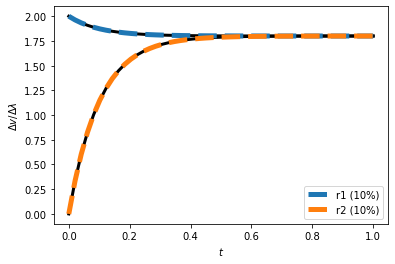

In [26]:
## Plot
plotSensitivity(dat,)


## Sensitivity Bond Graph -- change $K_B$

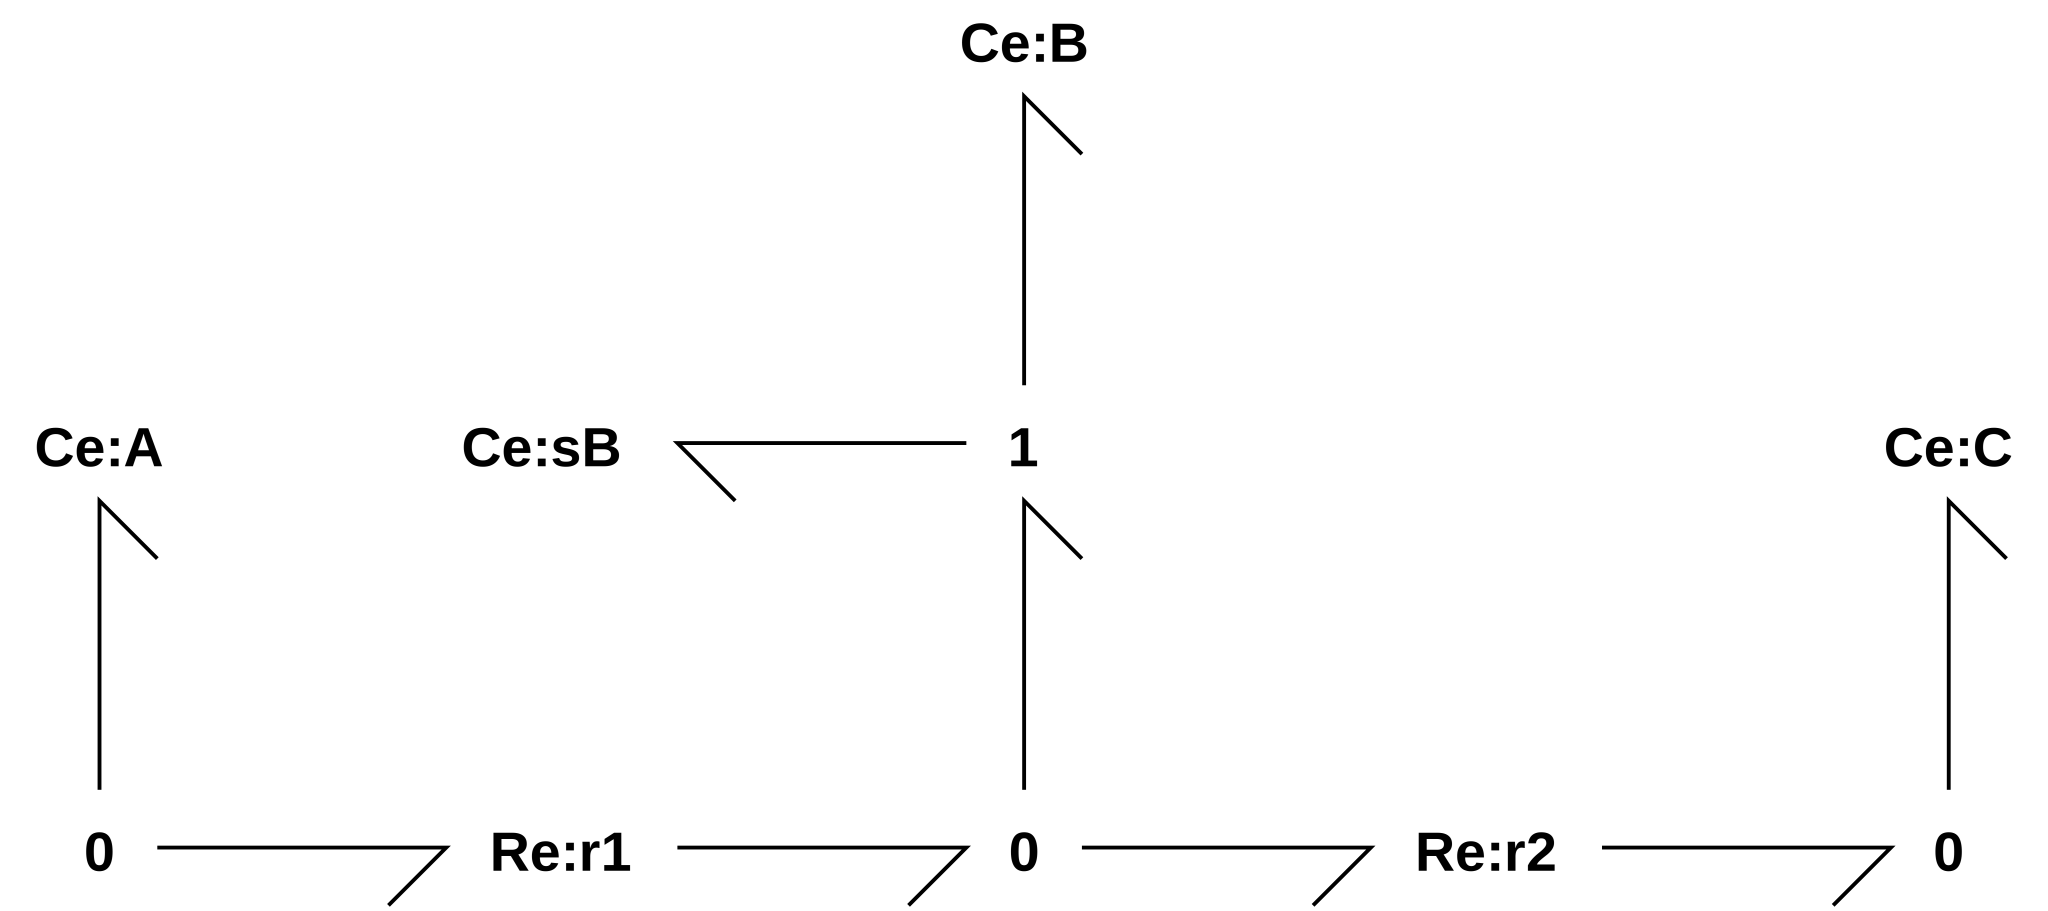

In [27]:
# Simple example A = B = C: sensitivity
sbg.model('sKABC_abg.svg')
import sKABC_abg
disp.SVG('sKABC_abg.svg')

### Stoichiometry & linearisation

In [28]:
## Stoichiometry
s,sc,sf = Stoichiometry(sKABC_abg.model(),chemostats=['A','C','sB'],flowstats=[])

## Linearise
Sys,X_ss,V_ss,dX_ss = Linear(s,sc,parameter=parameter,X0=[2,1,1,1],quiet=quiet)

## Extract sensitivity system
inp = ['sB']
outp = ['r1','r2']
sys = extractSubsystem(Sys,sc,sf,inp,outp)

## Species and reactions
print(s['species'])
print(s['reaction'])

Steady-state finder error: 8.88e-16
X_ss = [2.  1.1 1.  1. ]
V_ss = [0.9 0.9]
['A', 'B', 'C', 'sB']
['r1', 'r2']


In [29]:
## Show transfer function
con.tf(sys)


TransferFunction([[array([-1.1,  0. ])], [array([9.9, 0. ])]], [[array([ 1., 10.])], [array([ 1., 10.])]])

In [30]:
## System matrix
sys

<LinearIOSystem:sys[7]:['u[0]']->['y[0]', 'y[1]']>

In [31]:
## Show dc gain
print('DC gain: \n', con.dcgain(sys))

DC gain: 
 [[0.]
 [0.]]


### Compare sensitivity with exact simulation

In [32]:
## Exact Simulate with changed K
parameter1 = copy.copy(parameter)
parameter1['K_B'] *= lam
t = np.linspace(0,1)
dat = st.sim(s,sc=sc,t=t,parameter=parameter1,X0=X_ss,quiet=quiet)


In [33]:
## Step response to sB
y_lin = linStep(sc,sys,T=t)

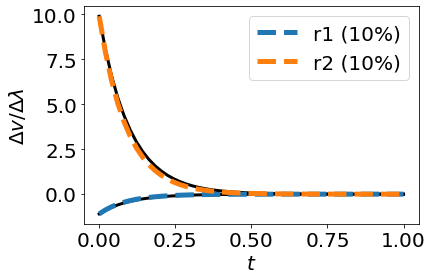

In [34]:
## Plot
plotSensitivity(dat,)


## Sensitivity Bond Graph -- change $\kappa_1$

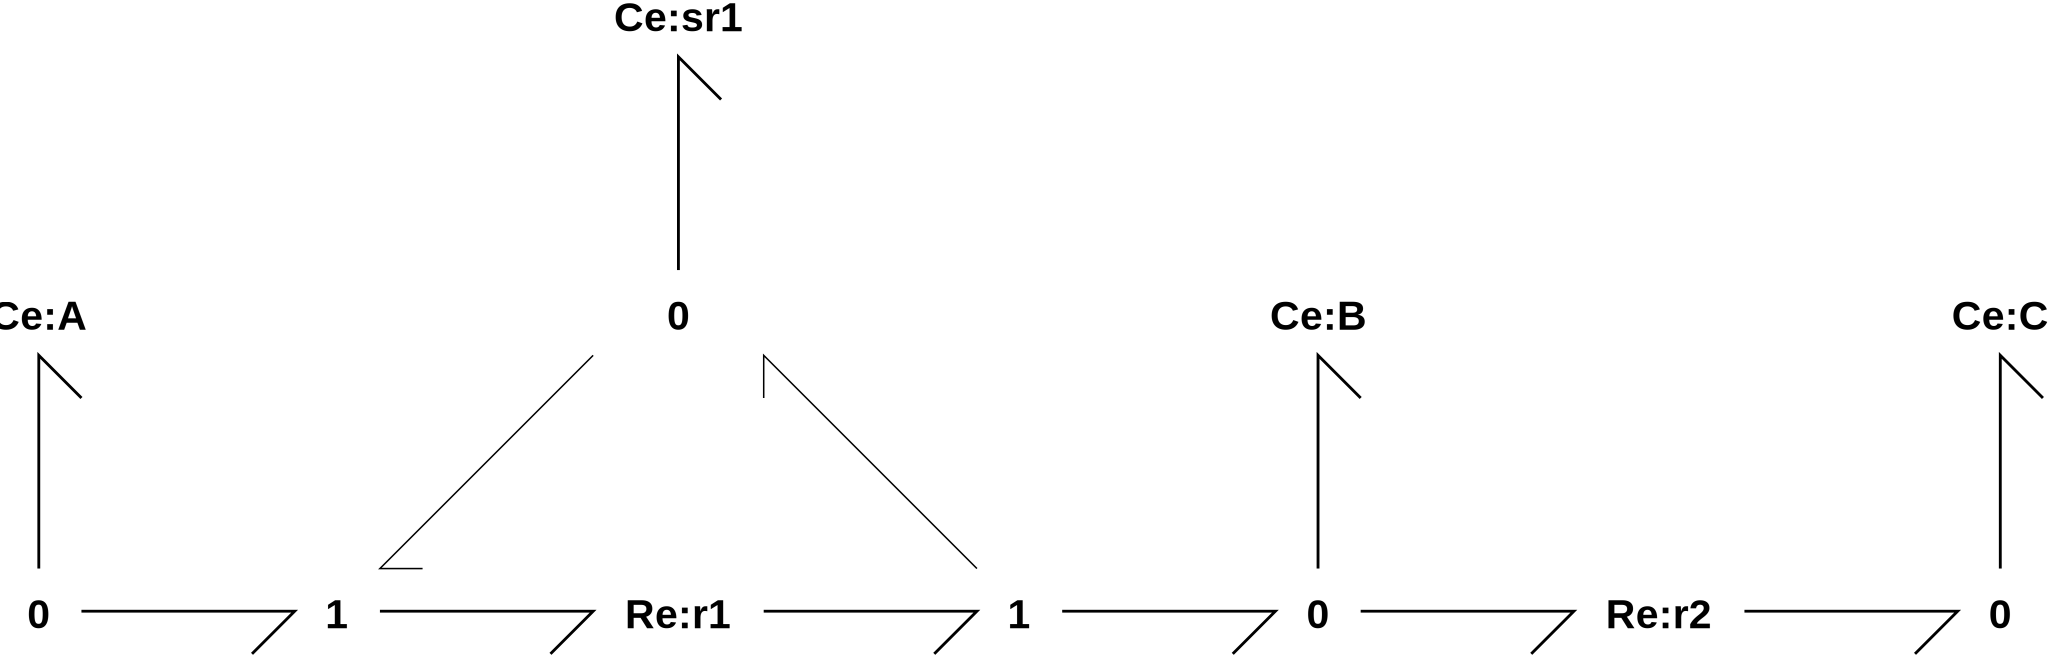

In [35]:
# Simple example A = B = C: sensitivity
sbg.model('sKapABC_abg.svg')
import sKapABC_abg
disp.SVG('sKapABC_abg.svg')

In [36]:
## BG generated equations
model = sKapABC_abg.model()
for cr in model.constitutive_relations:
    print(cr)
    #print(sp.diff(cr,'x_0'))


K_A*K_sr1*kappa_r1*x_0*x_3 - K_B*K_sr1*kappa_r1*x_1*x_3 + dx_0
-K_A*K_sr1*kappa_r1*x_0*x_3 + K_B*K_sr1*kappa_r1*x_1*x_3 + K_B*kappa_r2*x_1 - K_C*kappa_r2*x_2 + dx_1
-K_B*kappa_r2*x_1 + K_C*kappa_r2*x_2 + dx_2
dx_3


### Stoichiometry & linearisation

In [37]:
print(s['reaction'])
## Stoichiometry
s,sc,sf = Stoichiometry(sKapABC_abg.model(),chemostats=['A','C','sr1'])
print(sf['flowstats'])

## Linearise
Sys,X_ss,V_ss,dX_ss = Linear(s,sc,parameter=parameter,X0=[2,1,1,1],quiet=quiet)

## Extract sensitivity system
inp = ['sr1']
outp = ['r1','r2']
sys = extractSubsystem(Sys,sc,sf,inp,outp)

## Show transfer function
con.tf(sys)


['r1', 'r2']
[]
Steady-state finder error: 8.88e-16
X_ss = [2.  1.1 1.  1. ]
V_ss = [0.9 0.9]


TransferFunction([[array([0.9, 8.1])], [array([8.1])]], [[array([ 1., 10.])], [array([ 1., 10.])]])

In [38]:
## System matrix
sys

<LinearIOSystem:sys[10]:['u[0]']->['y[0]', 'y[1]']>

In [39]:
## Show dc gain
print('DC gain: \n', con.dcgain(sys))

DC gain: 
 [[0.81]
 [0.81]]


### Compare sensitivity with exact simulation

In [40]:
## Exact Simulate with changed K
lam = 1.1
parameter1 = copy.copy(parameter)
parameter1['kappa_r1'] *= lam
t = np.linspace(0,1)
dat = st.sim(s,sc=sc,sf=sf,t=t,parameter=parameter1,X0=X_ss,quiet=quiet)


In [41]:
## Step response to sB
y_lin = linStep(sc,sys,T=t)

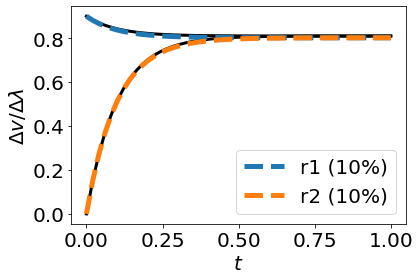

In [42]:
## Plot
plotSensitivity(dat,)

In [43]:
sys

<LinearIOSystem:sys[10]:['u[0]']->['y[0]', 'y[1]']>

In [44]:
disp.Latex(st.sprintvl(s))

<IPython.core.display.Latex object>

# Sensitivity components

## sCe

### Bond Graph

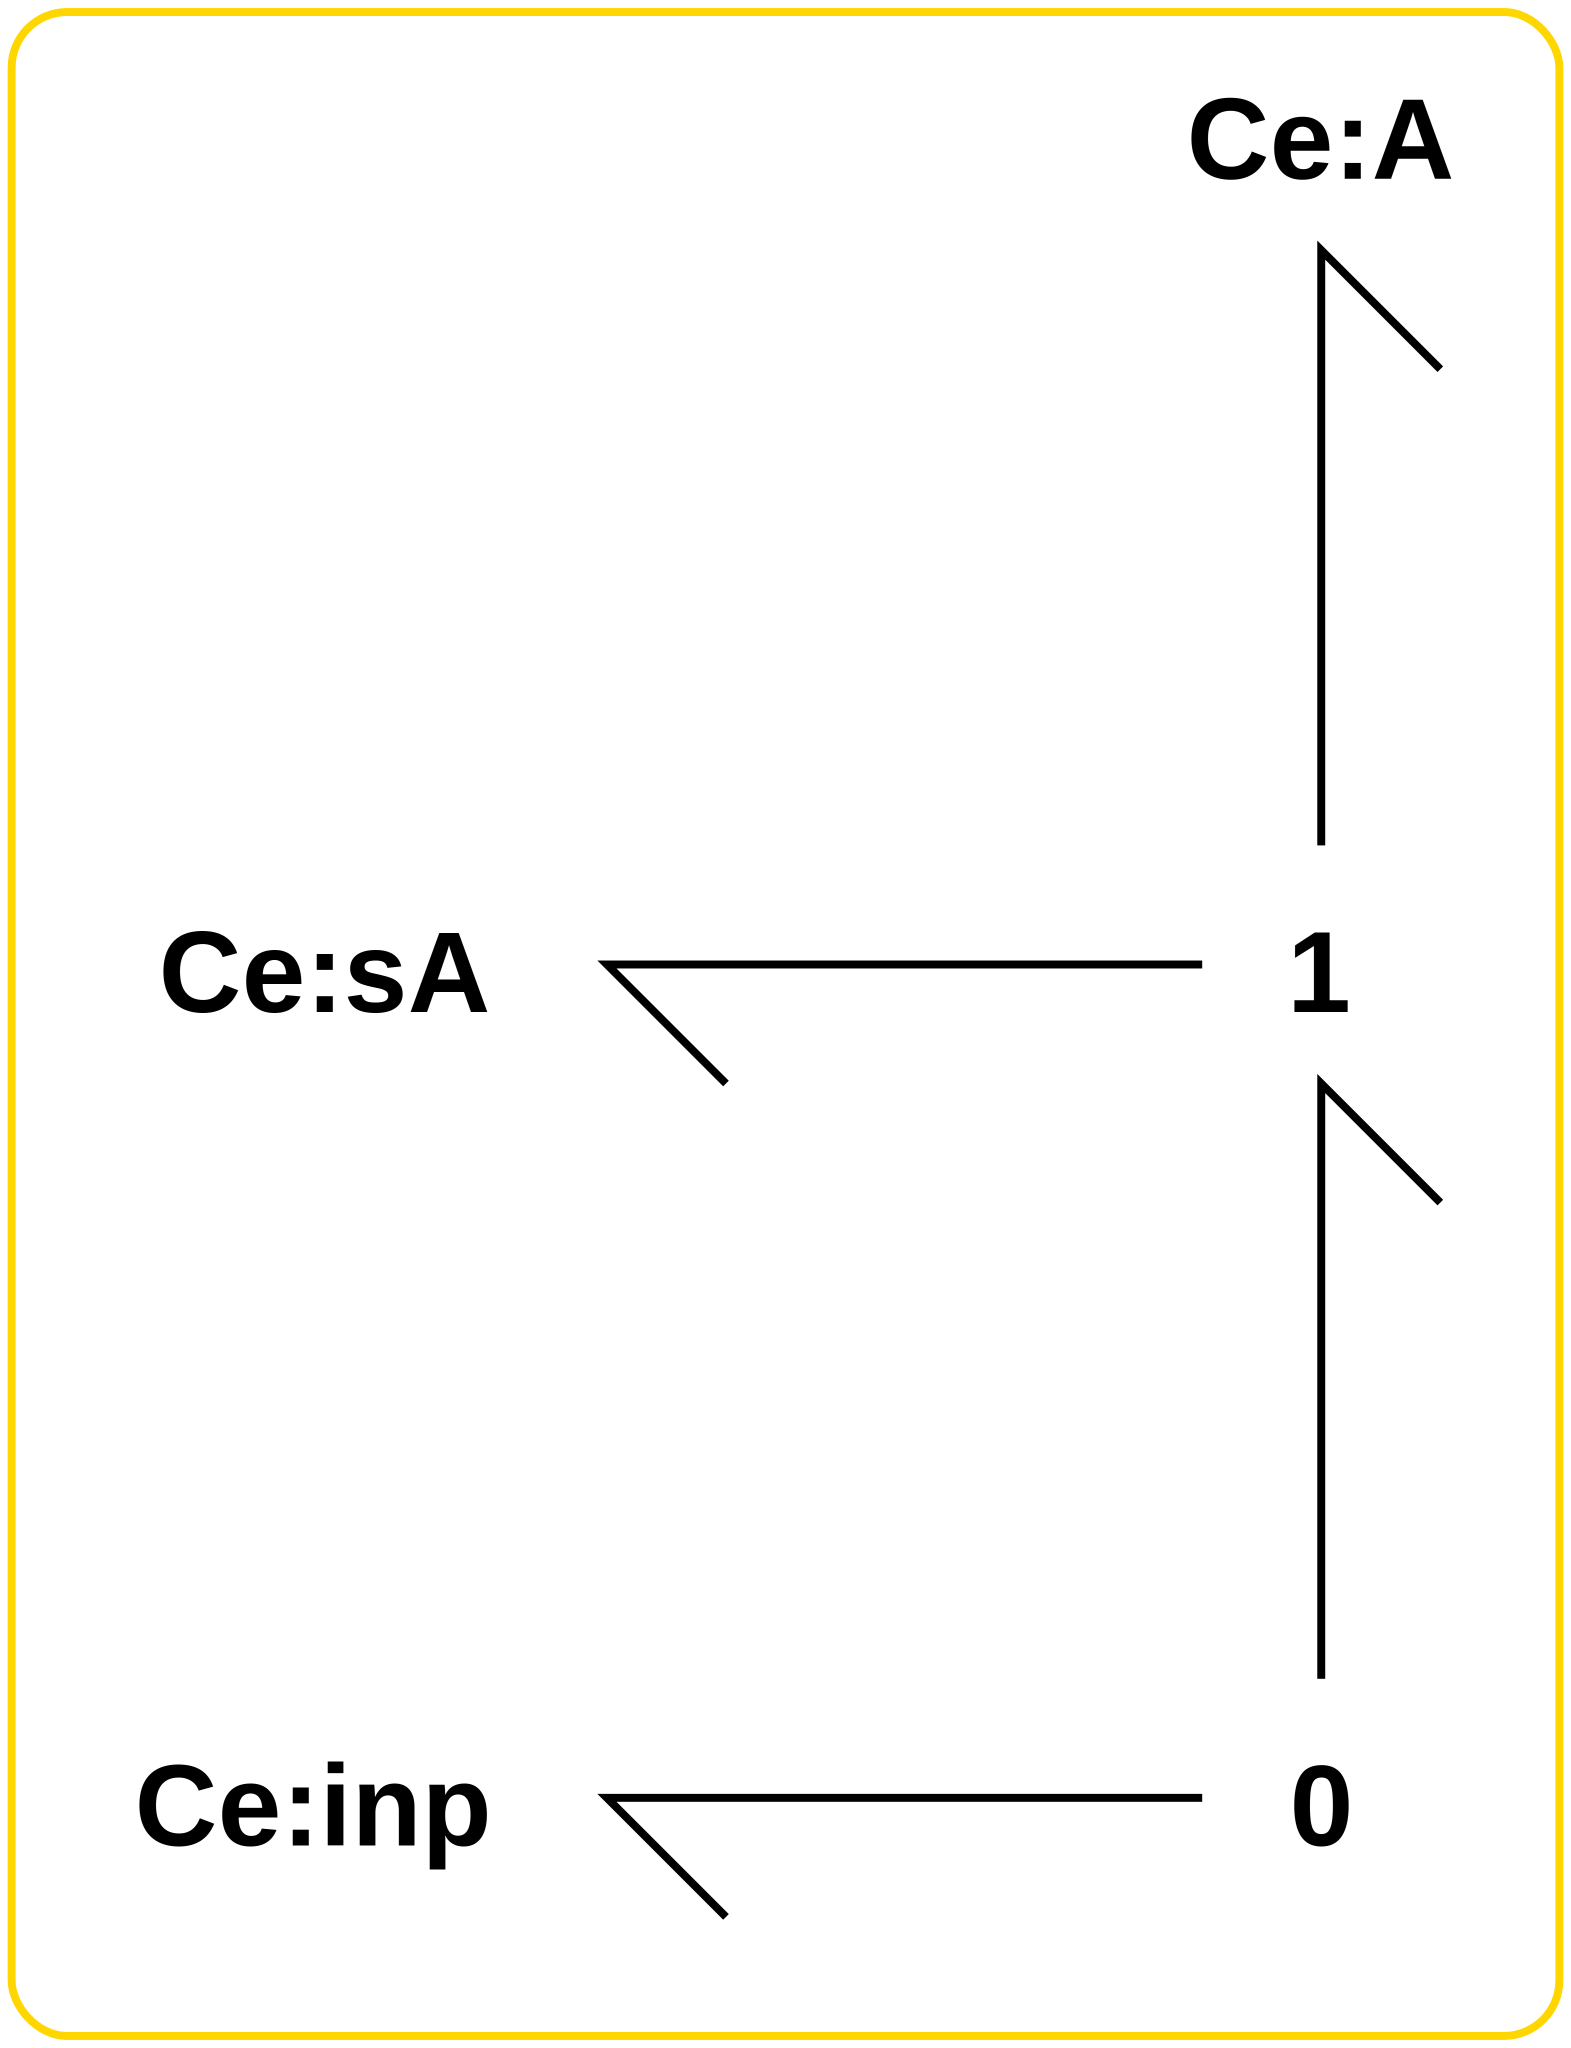

In [45]:
# sCe
sbg.model('sCe_abg.svg')
import sCe_abg
disp.SVG('sCe_abg.svg')

## sRe

### Bond Graph

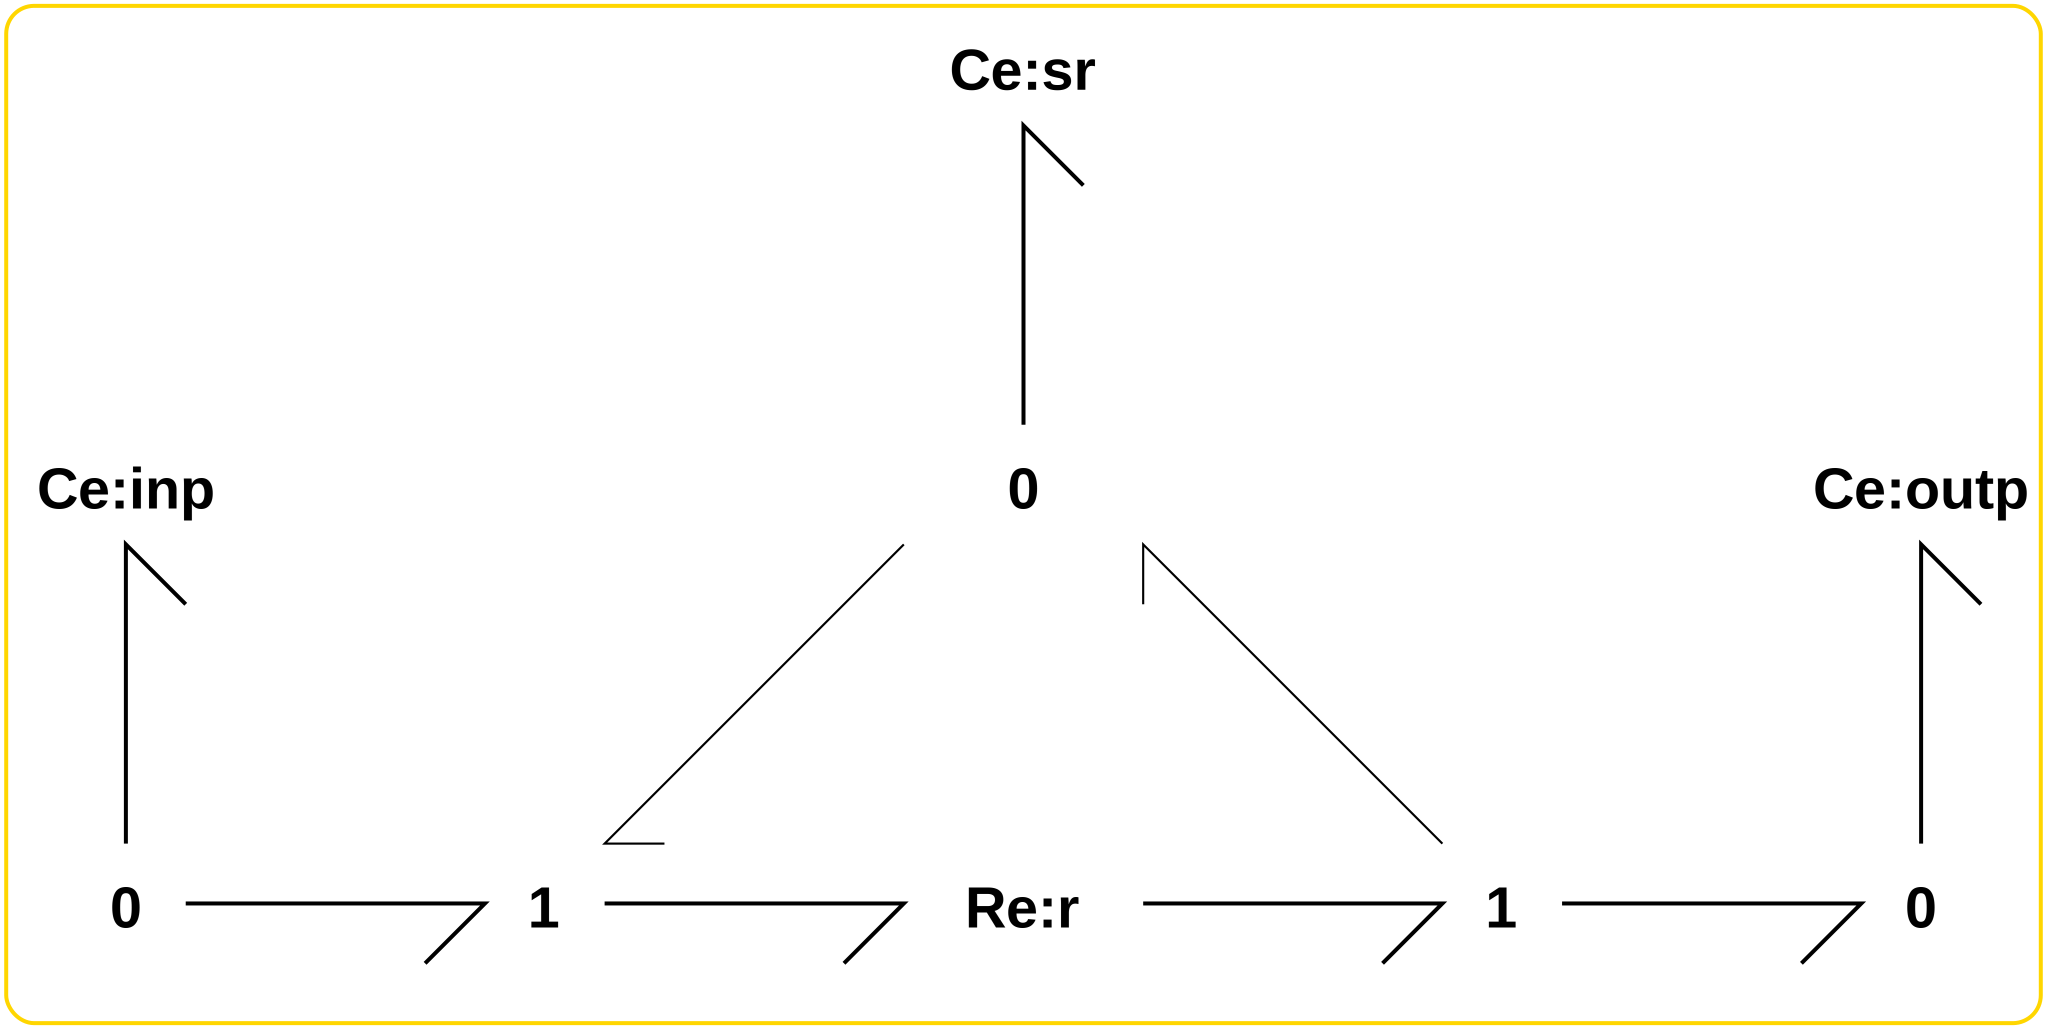

In [46]:
# sRe
sbg.model('sRe_abg.svg')
import sRe_abg
disp.SVG('sRe_abg.svg')

## Simple system revisited

Creating subsystem: sCe:B
Creating subsystem: sRe:r1
Creating subsystem: sRe:r2


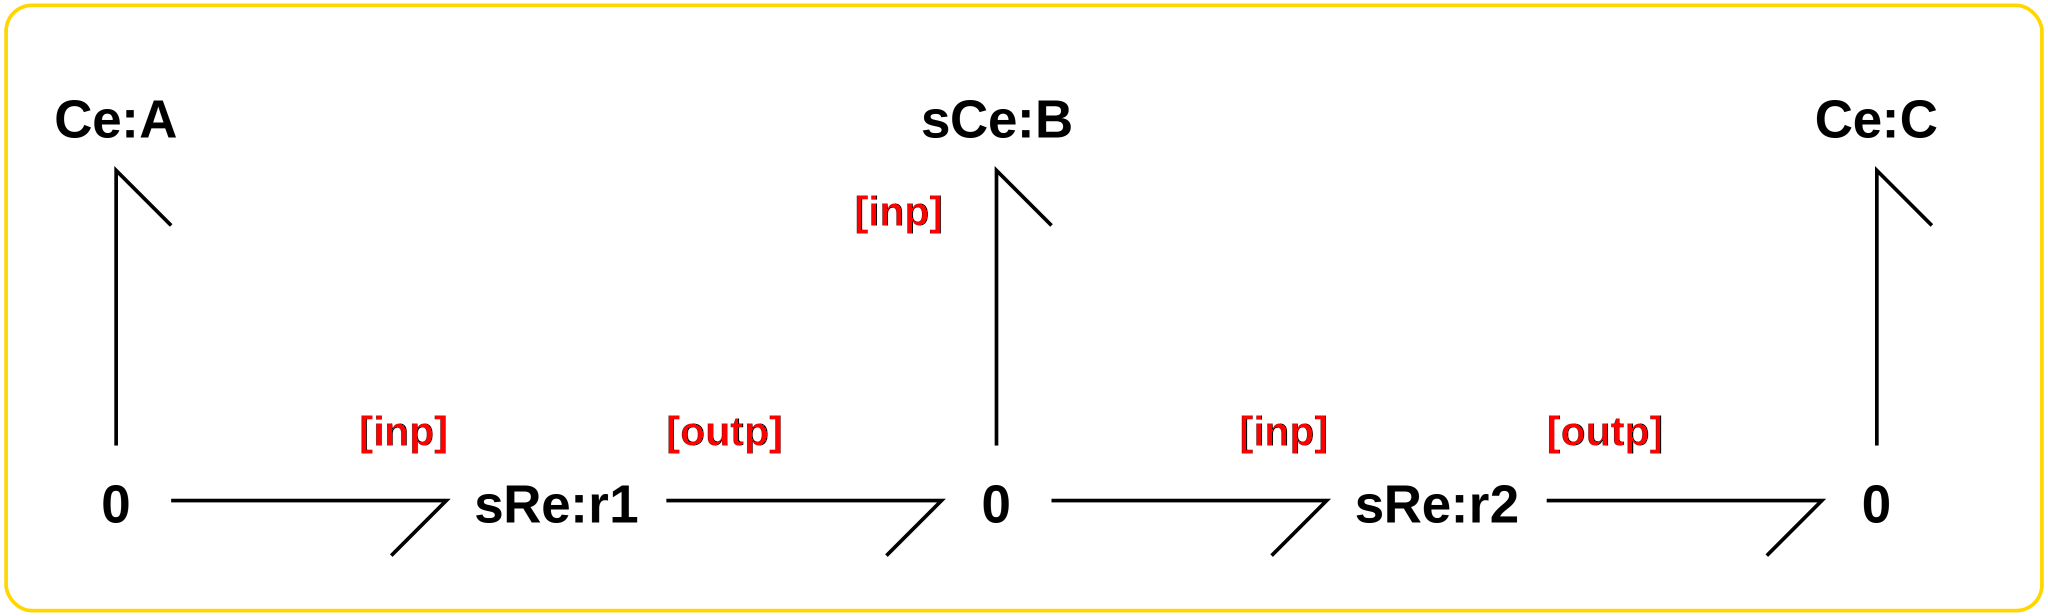

In [47]:
# Simple example A = B = C with sensitivity components
sbg.model('sABC_abg.svg')
import sABC_abg
disp.SVG('sABC_abg.svg')

### Parameters

In [48]:
## Parameters
parameter = {}
parameter['K_A'] = 1
parameter['K_B_A'] = 1
parameter['kappa_r1'] = 0.1
parameter['kappa_r2'] = 0.9
print(parameter)

## Initial states
X_A_0 = 2

{'K_A': 1, 'K_B_A': 1, 'kappa_r1': 0.1, 'kappa_r2': 0.9}


In [49]:
## Parameters
parameter = {}
parameter['K_A'] = 1
parameter['K_B_A'] = 1
parameter['kappa_r1'] = 1
parameter['kappa_r2'] = 9
print(parameter)

## Initial states
X_A_0 = 2

{'K_A': 1, 'K_B_A': 1, 'kappa_r1': 1, 'kappa_r2': 9}


### Stoichiometry & linearisation

In [50]:
## Stoichiometry
s,sc,sf = Stoichiometry(sABC_abg.model(),chemostats=['A','C','B_sA','r1_sr','r2_sr'],flowstats=[])

## Species
print(s['species'])

## Reactions
print(s['reaction'])

## Linearise
Sys,X_ss,V_ss,dX_ss = Linear(s,sc,parameter=parameter,X0=[X_A_0,1,1,1,1,1],quiet=quiet)


## Lambda for comparison
lam = 1.1

['A', 'C', 'B_A', 'B_sA', 'r1_sr', 'r2_sr']
['r1', 'r2']
Steady-state finder error: 8.88e-16
X_ss = [2.  1.  1.1 1.  1.  1. ]
V_ss = [0.9 0.9]


In [51]:
## Show reactions
disp.Latex(st.sprintrl(s,all=True,chemformula=True))

<IPython.core.display.Latex object>

In [52]:
## Show system
Sys

<LinearIOSystem:sys[12]:['u[0]', 'u[1]', 'u[2]', 'u[3]', 'u[4]']->['y[0]', 'y[1]']>

In [53]:
## Show transfer function
con.tf(Sys)

TransferFunction([[array([1., 9.]), array([-9.]), array([-1.1,  0. ]), array([0.9, 8.1]), array([0.9])], [array([9.]), array([-9., -9.]), array([9.9, 0. ]), array([8.1]), array([0.9, 0.9])]], [[array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.])], [array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.])]])

### Stoichiometric matrix

In [54]:
disp.Latex(st.sprintl(s,'N'))

<IPython.core.display.Latex object>

In [55]:
disp.Latex(st.sprintl(s,'Nf'))

<IPython.core.display.Latex object>

In [56]:
disp.Latex(st.sprintl(s,'Nr'))

<IPython.core.display.Latex object>

In [57]:
## Show dc gain
print('DC gain: \n', con.dcgain(Sys))

DC gain: 
 [[ 0.9  -0.9   0.    0.81  0.09]
 [ 0.9  -0.9   0.    0.81  0.09]]



## Sensitivity Bond Graph -- change B

In [58]:
## Extract sensitivity system
inp = ['B_sA']
outp = ['r1','r2']
sys = extractSubsystem(Sys,sc,sf,inp,outp)


In [59]:
## Show transfer function
con.tf(sys)


TransferFunction([[array([-1.1,  0. ])], [array([9.9, 0. ])]], [[array([ 1., 10.])], [array([ 1., 10.])]])

In [60]:
## System matrix
sys

<LinearIOSystem:sys[14]:['u[0]']->['y[0]', 'y[1]']>

In [61]:
## Show dc gain
print('DC gain: \n', con.dcgain(sys))

DC gain: 
 [[0.]
 [0.]]


### Compare sensitivity with exact simulation

In [62]:
## Exact Simulate with changed K
parameter1 = copy.copy(parameter)
parameter1['K_B_A'] *= lam
t = np.linspace(0,1)
dat = st.sim(s,sc=sc,t=t,parameter=parameter1,X0=X_ss,quiet=quiet)


In [63]:
## Step response to sB
y_lin = linStep(sc,sys,T=t)

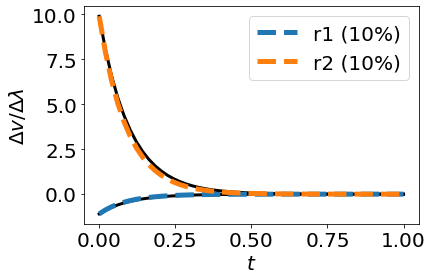

In [64]:
## Plot
plotSensitivity(dat,)


## Sensitivity Bond Graph -- change r1

In [65]:
## Extract sensitivity system
inp = ['r1_sr']
outp = ['r1','r2']
sys = extractSubsystem(Sys,sc,sf,inp,outp)


In [66]:
## Show transfer function
con.tf(sys)


TransferFunction([[array([0.9, 8.1])], [array([8.1])]], [[array([ 1., 10.])], [array([ 1., 10.])]])

In [67]:
## System matrix
sys

<LinearIOSystem:sys[16]:['u[0]']->['y[0]', 'y[1]']>

In [68]:
## Show dc gain
print('DC gain: \n', con.dcgain(sys))

DC gain: 
 [[0.81]
 [0.81]]


### Compare sensitivity with exact simulation

In [69]:
## Exact Simulate with changed r1
parameter1 = copy.copy(parameter)
parameter1['kappa_r1'] *= lam
t = np.linspace(0,1)
dat = st.sim(s,sc=sc,t=t,parameter=parameter1,X0=X_ss,quiet=quiet)
print(parameter1)

{'K_A': 1, 'K_B_A': 1, 'kappa_r1': 1.1, 'kappa_r2': 9}


In [70]:
## Step response to sr1
y_lin = linStep(sc,sys,T=t)

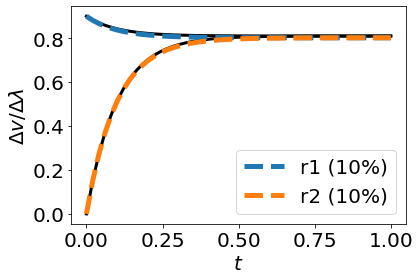

In [71]:
## Plot
plotSensitivity(dat,)


## Sensitivity Bond Graph -- change r2

In [72]:
## Extract sensitivity system
inp = ['r2_sr']
outp = ['r1','r2']
sys = extractSubsystem(Sys,sc,sf,inp,outp)


In [73]:
## Show transfer function
con.tf(sys)


TransferFunction([[array([0.9])], [array([0.9, 0.9])]], [[array([ 1., 10.])], [array([ 1., 10.])]])

In [74]:
## System matrix
sys

<LinearIOSystem:sys[18]:['u[0]']->['y[0]', 'y[1]']>

In [75]:
## Show dc gain
print('DC gain: \n', con.dcgain(sys))

DC gain: 
 [[0.09]
 [0.09]]


### Compare sensitivity with exact simulation

In [76]:
## Exact Simulate with changed r2
parameter1 = copy.copy(parameter)
parameter1['kappa_r2'] *= lam
t = np.linspace(0,1)
dat = st.sim(s,sc=sc,t=t,parameter=parameter1,X0=X_ss,quiet=quiet)
print(parameter1)
print(X_ss)

{'K_A': 1, 'K_B_A': 1, 'kappa_r1': 1, 'kappa_r2': 9.9}
[2.  1.  1.1 1.  1.  1. ]


In [77]:
## Step response to sr2
y_lin = linStep(sc,sys,T=t)

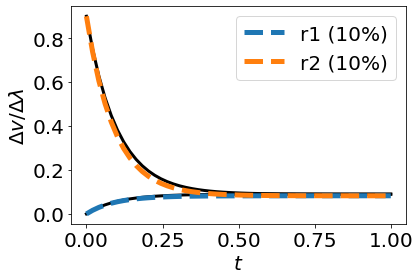

In [78]:
## Plot
plotSensitivity(dat,)

# Stoichiometric approach

## Supporting software

In [79]:
def stoichSensitivity(model,chemostats=['A','C'], parameter={},X0=None,CommonSpecies=None):
    """Sensitivity analysis  via stoichiometric approach """
    
    ## Stoichiometry
    s,sc,sf = Stoichiometry(model,chemostats=chemostats,CommonSpecies=CommonSpecies,sensitivity=True)

    ## Linearise
    if X0 is None:
        X0 = np.ones(s['n_X'])
        i_chem = s['species'].index(chemostats[0])
        X0[i_chem] = 2
    
    Sys,X_ss,V_ss,dX_ss = Linear(s,sc,parameter=parameter,X0=X0,quiet=quiet)
    
    return s,sc,sf,Sys,X_ss,V_ss,dX_ss


def simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,chemostats=['A','C'],
                   inp=['sr1'],outp=['r1','r2'],t_last=2,parameter={},lam=1.2,order=None,sX0=None):

    ## Extract sensitivity system
    sys = extractSubsystem(Sys,sc,sf,inp=inp,outp=outp,order=order)

    ## Time
    t = np.linspace(0,t_last,500)
    
    ## Sensitivity step response
#     step = con.step_response(sys,T=t)
#     y_lin = step.y[:,0,:].T
    y_lin = linStep(sc,sys,T=t,X0=sX0)
    
    ## Exact simulation with changed parameter or state
    X_ss_1 = copy.copy(X_ss)
    parameter1 = copy.copy(parameter)
    inComp = inp[0][1:]
    
    if sX0 is None:
        ## Parameter or chemostat perturbation
        if inComp in chemostats:
            ## Perturb state
            iComp = s['species'].index(inComp)
            X_ss_1[iComp] = lam*X_ss_1[iComp]
    #         y_lin *= X_ss_1[iComp]
        else:
            ## Perturb parameter
            if inComp[0].isupper():
                parname = 'K_'+inComp
            else:
                parname = 'kappa_'+inComp

            if parname in list(parameter.keys()):
                parameter1[parname] = lam*parameter[parname]
            else:
                parameter1[parname] = lam

        dat = st.sim(s,sc=sc,sf=sf,t=t,parameter=parameter1,X0=X_ss_1,quiet=quiet,Normalise=Normalise)
    else:
        ## Initial condition perturbation.
        X_ss_1 += (lam-1)*sX0
        dat = st.sim(s,sc=sc,sf=sf,t=t,parameter=parameter1,X0=X_ss_1,quiet=quiet,Normalise=Normalise)

    return dat,y_lin,t,sys



## Simple example A = B = C

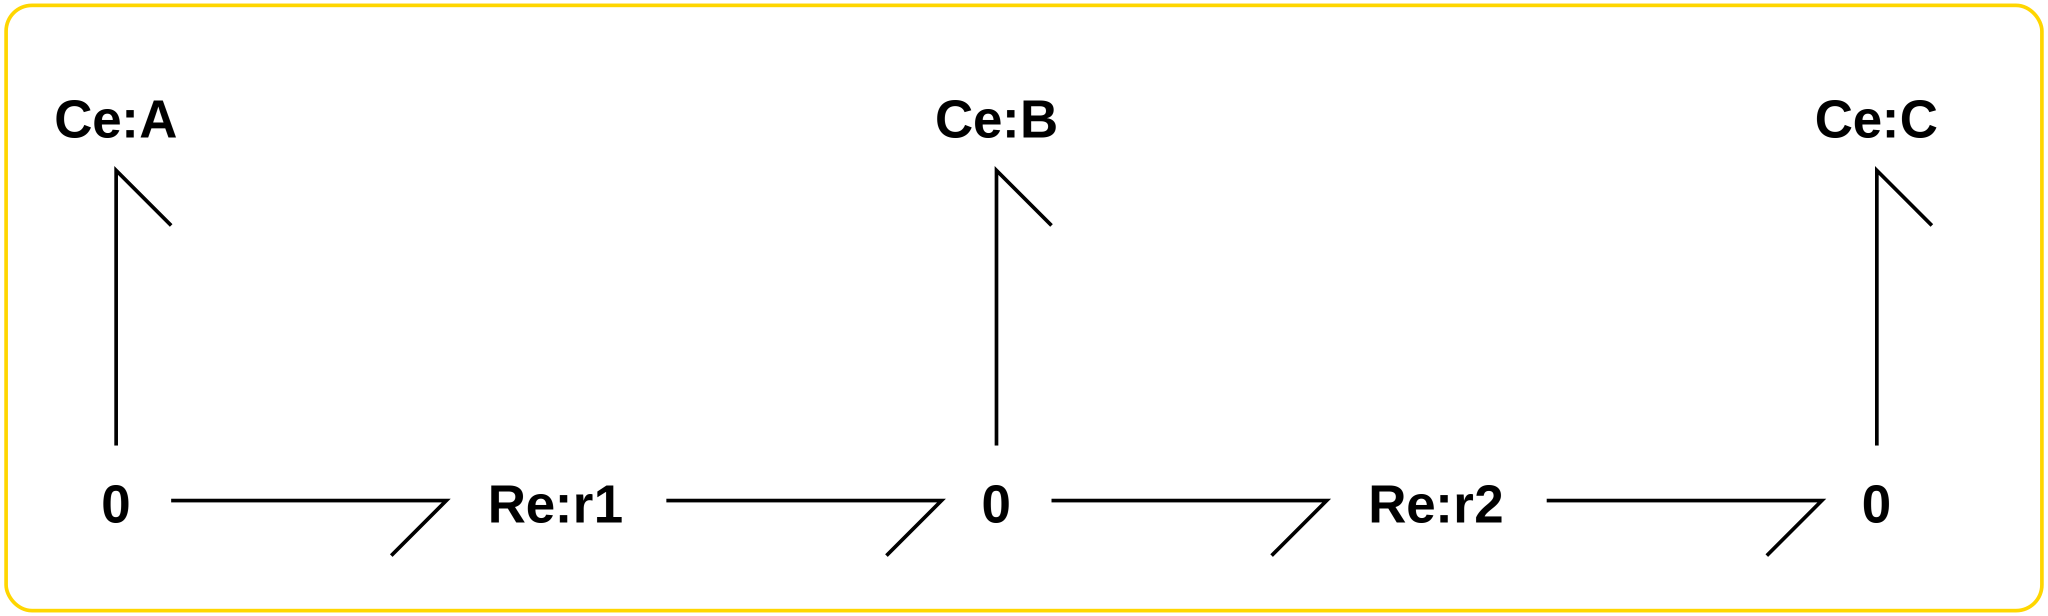

In [80]:
# Simple example A = B = C
sbg.model('ABC_abg.svg')
import ABC_abg
disp.SVG('ABC_abg.svg')

In [81]:
## Parameters
parameter = {}
parameter['K_A'] = 1
parameter['K_B'] = 1
parameter['kappa_r1'] = 1
parameter['kappa_r2'] = 9
print(parameter)

## Initial states
X_A_0 = 2


{'K_A': 1, 'K_B': 1, 'kappa_r1': 1, 'kappa_r2': 9}


Steady-state finder error: 8.88e-16
X_ss = [2.  1.1 1.  1.  1.  1.  1.  1. ]
V_ss = [0.9 0.9]


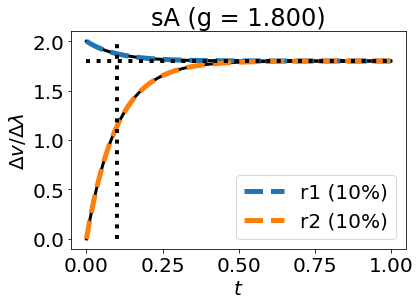

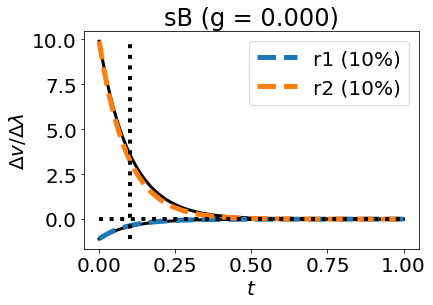

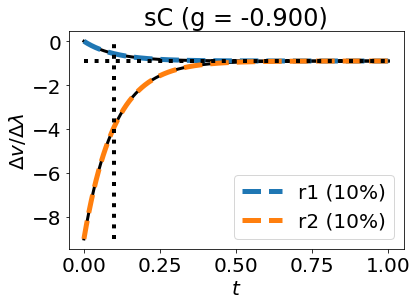

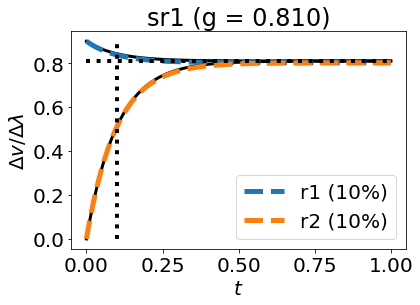

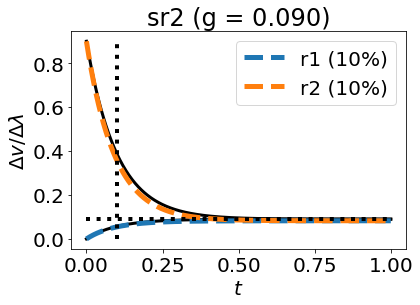

In [82]:
## ABC model
dcgain = {}
s,sc,sf,Sys,X_ss,V_ss,dX_ss = stoichSensitivity(ABC_abg.model(),parameter=parameter)
lam = 1.1
outp = ['r1','r2']
for inp in ['sA','sB','sC','sr1','sr2']:
    dat,y_lin,t,sys = simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,
                                      parameter=parameter,inp=[inp],outp=outp,lam=lam,t_last=1)
#     g = con.dcgain(sys)[0][0]

    g,tau = tfProps(sys)
    dcgain[inp] = g
    if Titles:
        plt.title(f'{inp} (g = {g:.3f})')
    plotSensitivity(dat,reactions=outp)
    plotLines()
#     plt.hlines(g,min(t),max(t),color='black',ls='dashed')
    Savefig('ABC_'+inp)
    plt.show()

In [83]:
printLatex(s,sc=sc)

A &= \left(\begin{matrix}-10.0\end{matrix}\right)
B &= \left(\begin{matrix}1.0 & 9.0 & 2.0 & -11.0 & 9.0 & 0.9 & -0.900000000000001\end{matrix}\right)
C &= \left(\begin{matrix}-1.0\\9.0\end{matrix}\right)
D &= \left(\begin{matrix}1.0 & 0 & 2.0 & -1.1 & 0 & 0.9 & 0\\0 & -9.0 & 0 & 9.9 & -9.0 & 0 & 0.900000000000001\end{matrix}\right)
\begin{align}
X&= \begin{pmatrix}
    X_{A}\\
    X_{B}\\
    X_{C}\\
    X_{sA}\\
    X_{sB}\\
    X_{sC}\\
    X_{sr1}\\
    X_{sr2}\\
\end{pmatrix}
\end{align}

\begin{align}
V&= \begin{pmatrix}
    V_{r1}\\
    V_{r2}\\
\end{pmatrix}
\end{align}

\begin{align}
Nf &=
\left(\begin{matrix}1.0 & 0\\0 & 1.0\\0 & 0\\1.0 & 0\\0 & 1.0\\0 & 0\\1.0 & 0\\0 & 1.0\end{matrix}\right)
\end{align}

\begin{align}
Nr &=
\left(\begin{matrix}0 & 0\\1.0 & 0\\0 & 1.0\\0 & 0\\1.0 & 0\\0 & 1.0\\1.0 & 0\\0 & 1.0\end{matrix}\right)
\end{align}

\begin{align}
N &=
\left(\begin{matrix}-1.0 & 0\\1.0 & -1.0\\0 & 1.0\\-1.0 & 0\\1.0 & -1.0\\0 & 1.0\\0 & 0\\0 & 0\end{matrix}\right)
\en

### Vary $\lambda$

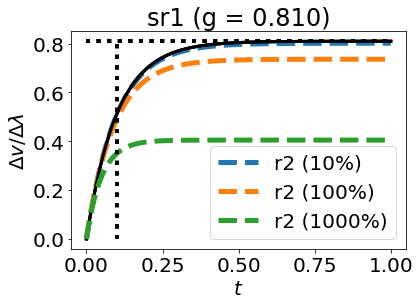

In [84]:
inp = 'sr1'
outp = ['r2']
for lam in [1.1,2,11]:
    dat,y_lin,t,sys = simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,
                                      parameter=parameter,inp=[inp],outp=outp,lam=lam,t_last=1)
#     print(con.dcgain(sys))
    g = con.dcgain(sys)
    if Titles:
        plt.title(f'{inp} (g = {g:.3f})')
    plotSensitivity(dat,reactions=outp)
    plotLines()
Savefig('ABC_lambda')

In [85]:
## Show system
Sys

<LinearIOSystem:sys[20]:['u[0]', 'u[1]', 'u[2]', 'u[3]', 'u[4]', 'u[5]', 'u[6]']->['y[0]', 'y[1]']>

In [86]:
## Show system TF
print(sc['chemostats'])
con.tf(Sys)

['A', 'C', 'sA', 'sB', 'sC', 'sr1', 'sr2']


TransferFunction([[array([1., 9.]), array([-9.]), array([ 2., 18.]), array([-1.1,  0. ]), array([-9.]), array([0.9, 8.1]), array([0.9])], [array([9.]), array([-9., -9.]), array([18.]), array([9.9, 0. ]), array([-9., -9.]), array([8.1]), array([0.9, 0.9])]], [[array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.])], [array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.]), array([ 1., 10.])]])

In [87]:
## Show DC gain
con.dcgain(Sys)

array([[ 0.9 , -0.9 ,  1.8 ,  0.  , -0.9 ,  0.81,  0.09],
       [ 0.9 , -0.9 ,  1.8 ,  0.  , -0.9 ,  0.81,  0.09]])

In [88]:
## Show initial reponse
print(Sys.D)

[[ 1.   0.   2.  -1.1  0.   0.9  0. ]
 [ 0.  -9.   0.   9.9 -9.   0.   0.9]]


### Sloppy parameters

ABC

 t_f = 1.00
H:
\sqrt\sigma_1 &= 0.82 & V_1\Lambda &= + 0.995 \lambda_{r1} + 0.097 \lambda_{r2}
\sqrt\sigma_2 &= 0.021 & V_2\Lambda &= + 0.995 \lambda_{r2} - 0.097 \lambda_{r1}
H_ss:
\sqrt\sigma_1 &= 0.81 & V_1\Lambda &= + 0.994 \lambda_{r1} + 0.110 \lambda_{r2}
\sqrt\sigma_2 &= 1e-06 & V_2\Lambda &= + 0.994 \lambda_{r2} - 0.110 \lambda_{r1}
Direct:
\sqrt\sigma_1 &= 0.81 & V_1\Lambda &= + 0.994 \lambda_{r1} + 0.110 \lambda_{r2}


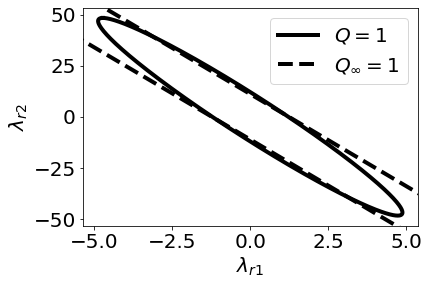

ABC

 t_f = 1.00
H:
\sqrt\sigma_1 &= 2 & V_1\Lambda &= + 0.914 \lambda_{A} - 0.407 \lambda_{C}
\sqrt\sigma_2 &= 0.19 & V_2\Lambda &= + 0.914 \lambda_{C} + 0.407 \lambda_{A}
H_ss:
\sqrt\sigma_1 &= 2 & V_1\Lambda &= + 0.894 \lambda_{A} - 0.447 \lambda_{C}
\sqrt\sigma_2 &= 1e-06 & V_2\Lambda &= + 0.894 \lambda_{C} + 0.447 \lambda_{A}
Direct:
\sqrt\sigma_1 &= 2 & V_1\Lambda &= + 0.894 \lambda_{A} - 0.447 \lambda_{C}


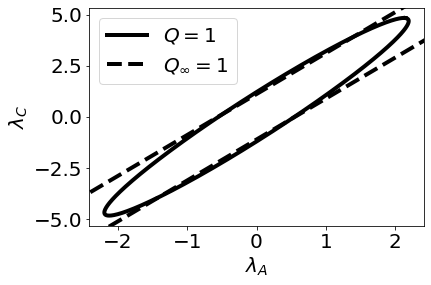

ABC

 t_f = 1000.00
H:
\sqrt\sigma_1 &= 0.82 & V_1\Lambda &= + 0.994 \lambda_{r1} + 0.109 \lambda_{r2}
\sqrt\sigma_2 &= 0.0099 & V_2\Lambda &= + 0.994 \lambda_{r2} - 0.109 \lambda_{r1}
H_ss:
\sqrt\sigma_1 &= 0.81 & V_1\Lambda &= + 0.994 \lambda_{r1} + 0.110 \lambda_{r2}
\sqrt\sigma_2 &= 1e-06 & V_2\Lambda &= + 0.994 \lambda_{r2} - 0.110 \lambda_{r1}
Direct:
\sqrt\sigma_1 &= 0.81 & V_1\Lambda &= + 0.994 \lambda_{r1} + 0.110 \lambda_{r2}


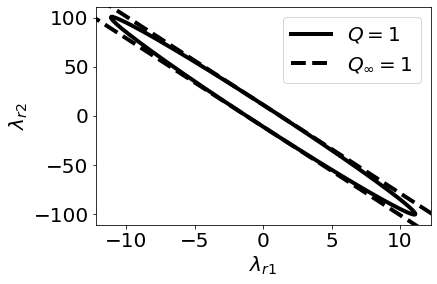

ABC

 t_f = 1000.00
H:
\sqrt\sigma_1 &= 2 & V_1\Lambda &= + 0.896 \lambda_{A} - 0.444 \lambda_{C}
\sqrt\sigma_2 &= 0.089 & V_2\Lambda &= + 0.896 \lambda_{C} + 0.444 \lambda_{A}
H_ss:
\sqrt\sigma_1 &= 2 & V_1\Lambda &= + 0.894 \lambda_{A} - 0.447 \lambda_{C}
\sqrt\sigma_2 &= 1e-06 & V_2\Lambda &= + 0.894 \lambda_{C} + 0.447 \lambda_{A}
Direct:
\sqrt\sigma_1 &= 2 & V_1\Lambda &= + 0.894 \lambda_{A} - 0.447 \lambda_{C}


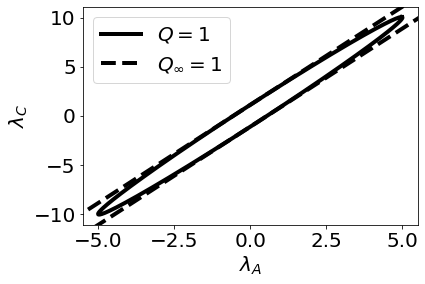

In [89]:
imp.reload(slp)

def sloppy(Sys,inp,outp,t=None,GainOnly=False):
    sys = extractSubsystem(Sys,sc,sf,inp,outp)
    #print(sys)
    H,eig,eigv,t = slp.Sloppy(sys,t=t,GainOnly=GainOnly)
    print(H)
    slp.SloppyPlot(eig,eigv,inp)
    slp.SloppyPrint(eig,eigv,inp,min_eig=0)
#     if not GainOnly:
#         slp.SloppyPlotData(t,y,inp,outp)
    
def sloppyBoth(Sys,inp,outp,t=1):
    
    sys = extractSubsystem(Sys,sc,sf,inp,outp)
    SysName = sc['name']
    print(SysName)
    if (max(t)<1e2):
        name = f'{SysName}_sloppy_{inp[0]}'
    else:
        name = f'{SysName}_sloppy_{inp[0]}_long'
        
    #print(sys)
    H,eig,eigv,t = slp.Sloppy(sys,t=t,GainOnly=False) 
    print(f'\n t_f = {max(t):0.2f}')
    print('H:')
    slp.SloppyPrint(eig,eigv,inp,min_eig=0)
    
    H,Eig,Eigv,t = slp.Sloppy(sys,t=t,GainOnly=True)
    print('H_ss:')
    slp.SloppyPrint(Eig,Eigv,inp,min_eig=0)
    
    ## Direct computation
    print('Direct:')
    gain = con.dcgain(sys)[0]
    norm = np.sum(gain*gain)
    ngain = gain/np.sqrt(norm)
    slp.SloppyPrint([norm],np.array([ngain]).T,inp,min_eig=0.0,min_eigv=0.05,max_eigs=2)
    
    ## Plot
    slp.SloppyPlot(eig,eigv,inp,Eig=Eig,Eigv=Eigv)
    
    Savefig(name) 
    plt.show()
    
for t_last in [1,1e3]:
    if t_last==0:
        t = None
    else:
        t = np.linspace(0,t_last,100)
    sloppyBoth(Sys,['sr1','sr2'],['r1'],t=t)
    sloppyBoth(Sys,['sA','sC'],['r1'],t=t)



## Example:  Enzyme-catalysed reaction

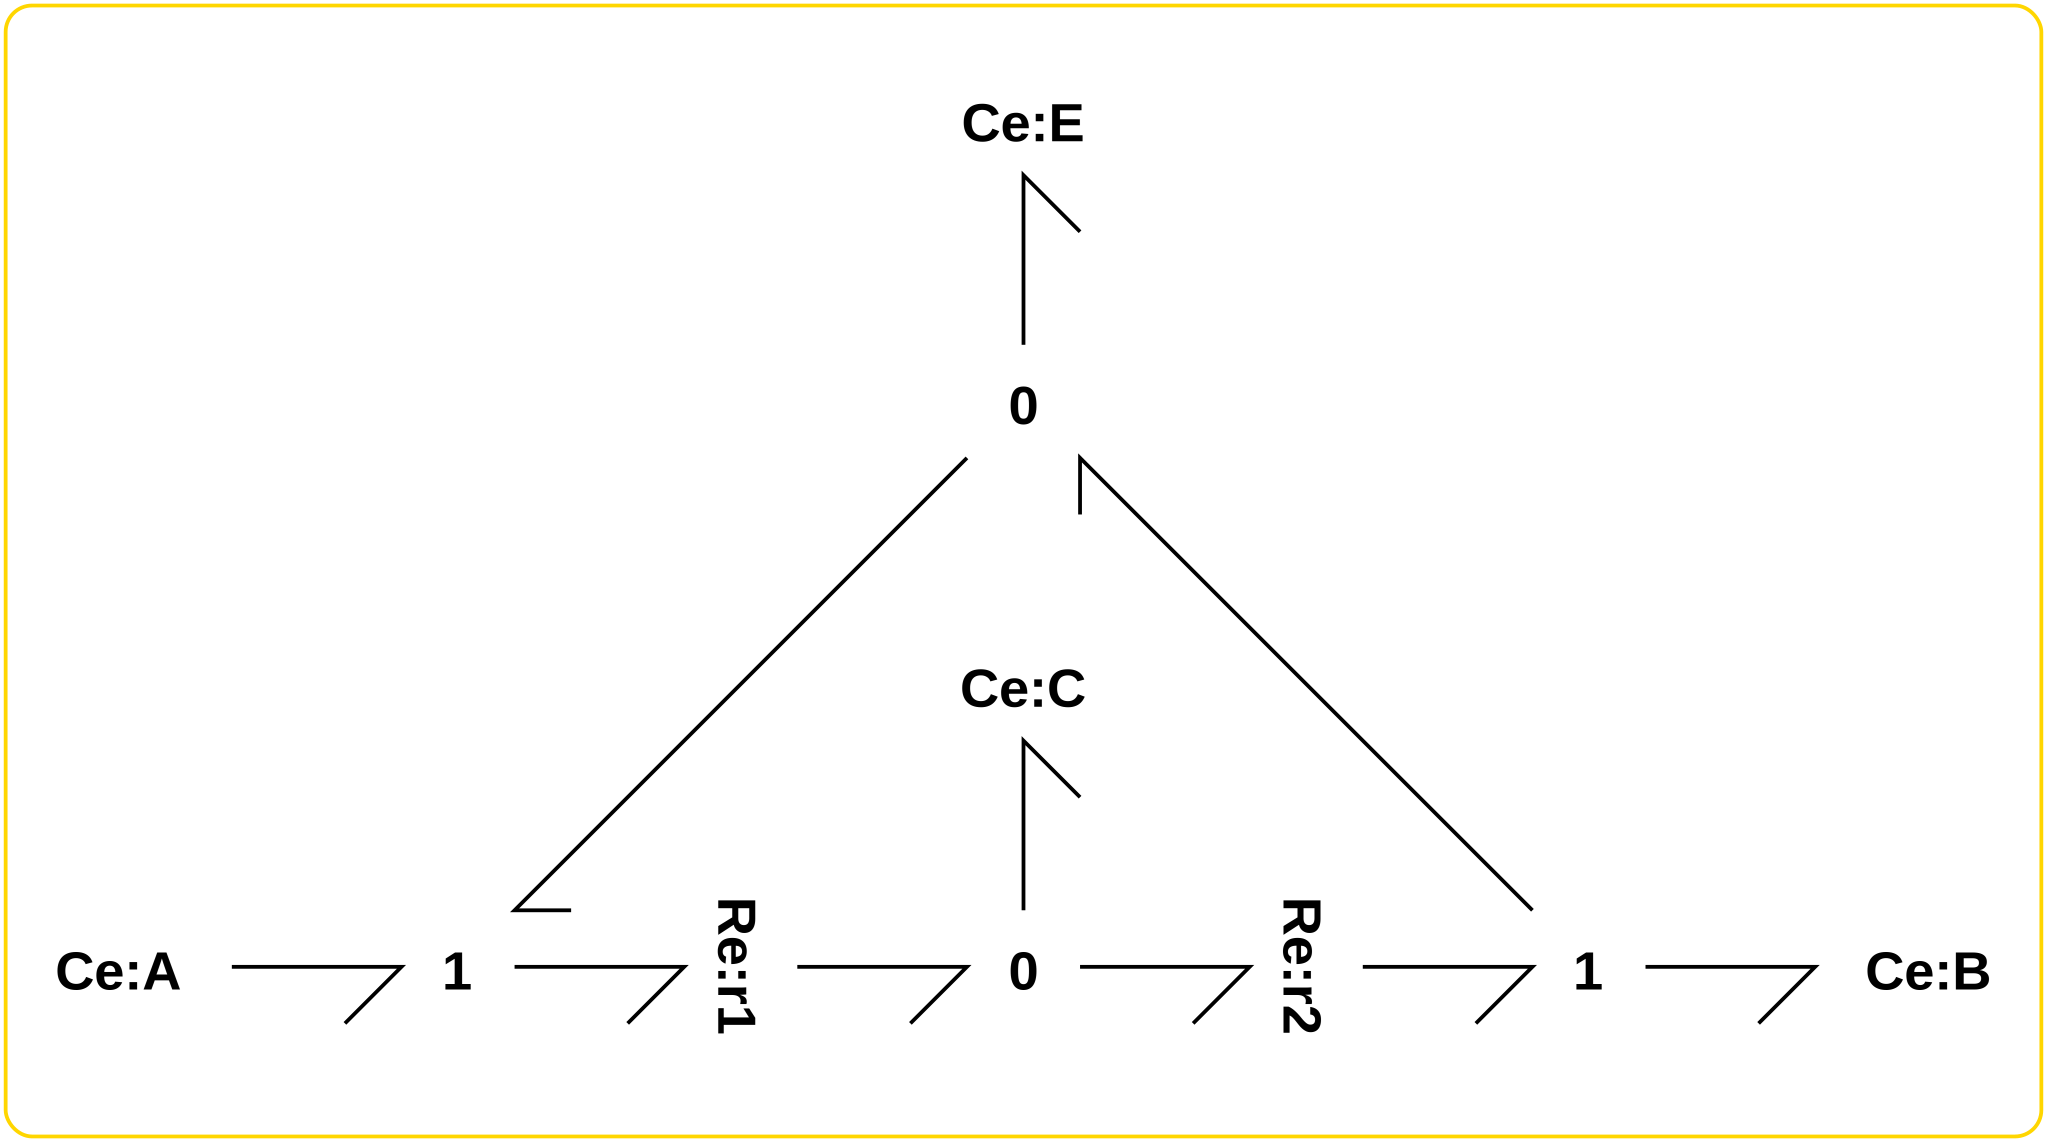

In [90]:
sbg.model('ECR_abg.svg')
import ECR_abg
imp.reload(ECR_abg)
disp.SVG('ECR_abg.svg')

In [91]:
## Stoichiometry
s0 = st.stoich(ECR_abg.model(),quiet=quiet)
species = s0['species']
reaction=s0['reaction']
n_X = s0['n_X']
n_V = s0['n_V']

In [92]:
## Initial states (for sensitivity system)
e0 = 10 ## Total bound and unbound enzyme
XX0 = {}
# XX0['A'] = 1
XX0['E'] = e0/2
XX0['C'] = e0/2
X0 = np.ones(2*n_X+n_V)

for spec in XX0:
    X0[species.index(spec)] = XX0[spec]

In [93]:
## Parameters
kappa_1 = 1
K_B = 1e-3

parameter = {}
parameter['K_A'] = 1
parameter['K_B'] = K_B
parameter['kappa_r1'] = kappa_1
parameter['kappa_r2'] = 1
print(parameter)


{'K_A': 1, 'K_B': 0.001, 'kappa_r1': 1, 'kappa_r2': 1}


In [94]:
## Chemostats
chemostats = ['A','B']

Steady-state finder error: 1.26e-15
X_ss = [1.    1.    3.336 6.664 1.    1.    1.    1.    1.    1.   ]
V_ss = [3.329 3.329]


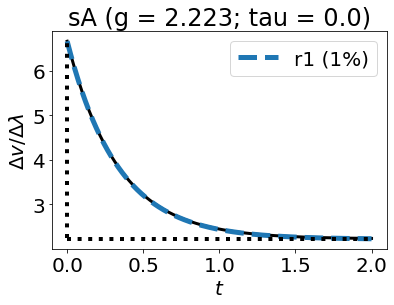

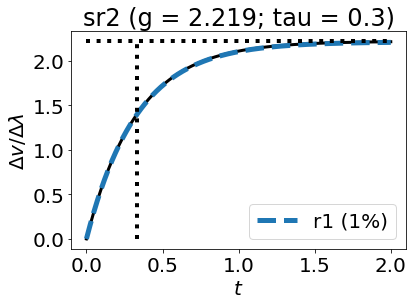

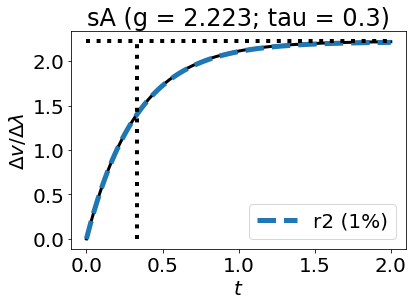

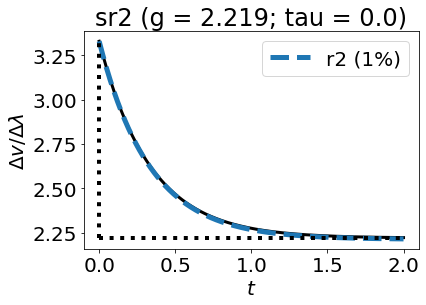

In [95]:
dcgain = {}
syss = {}
s,sc,sf,Sys,X_ss,V_ss,dX_ss = stoichSensitivity(ECR_abg.model(),parameter=parameter,chemostats=chemostats,X0=X0)
lam = 1.01
Outp = ['r1','r2']
Inp = ['sA','sr2']
t_last = 2/kappa_1
for outp in Outp:
    for inp in Inp:
        dat,y_lin,t,sys = simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,
                                          parameter=parameter,inp=[inp],outp=[outp],lam=lam,t_last=t_last)
        syss[inp] = sys
#         g = con.dcgain(sys)
        g,tau = tfProps(sys)
        dcgain[inp] = g
         #print(g)
        if Titles:
            plt.title(f'{inp} (g = {g:.3f}; tau = {tau:0.1f})')
        plotSensitivity(dat,reactions=[outp])
        plotLines()
        Savefig('ECR_'+inp+'_'+outp)
        plt.show()

### Vary $\lambda$

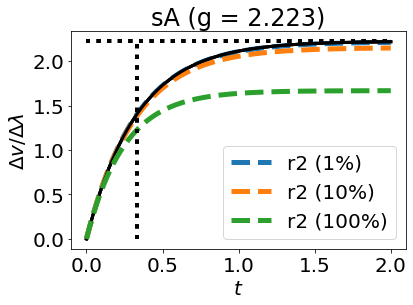

In [96]:
inp = 'sA'
outp = ['r2']
for lam in [1.01,1.1,2]:
    dat,y_lin,t,sys = simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,
                                      parameter=parameter,inp=[inp],outp=outp,lam=lam,t_last=t_last)
#     print(con.dcgain(sys))
    g,tau = tfProps(sys)
    if Titles:
        plt.title(f'{inp} (g = {g:.3f})')
    plotSensitivity(dat,reactions=outp)
    plotLines()
Savefig('ECR_lambda')

In [97]:
## Show system
#Sys

In [98]:
## Show system TFs
con.tf(syss['sA'])

TransferFunction(array([6.671]), array([1.   , 3.001]))

In [99]:
con.tf(syss['sr2'])

TransferFunction(array([3.329, 6.658]), array([1.   , 3.001]))

### Simulate over flow range - quasi steady-state. Supporting software

In [100]:
def QuasiSteadyState(Inp=['sAct','sInh'],points=10,x_max=100,grid=False):
    
    ## Extract info
    species = s['species']
    reaction = s['reaction']
    
    ### Simulate over flow range.
    ## Slow ramp for x_A
    X_chemo = {}
    t_d = 1e3
    t_last = 1e6
#     points = 50
    t = np.linspace(0,t_last,points)
    x_0 = 0.1
    X0[species.index('A')] = x_0
    slope = (x_max-x_0)/(t_last-t_d)
    X_chemo['A'] = f'({x_0} + {slope}*(t-{t_d})*(1*(t>{t_d})))'
    print(X_chemo)

    ## Steady-state
    X_ss,V_ss = SteadyState(s,sc,parameter=parameter,X0=X0)

    ## Simulate
    ndat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X_ss,X_chemo=X_chemo,quiet=quiet)

    ## Plot
#     st.plot(s,ndat,species=['E0','E','C'],reaction=['r2'])

    ## Plot flow v X_A
    ylabel = r'$\Delta f_2/\Delta \lambda}$'
    X_A = ndat['X'][:,species.index('A')]
    V_2 = ndat['V'][:,reaction.index('r2')]
    plt.plot(X_A,V_2,lw=5)
    if grid:
        plt.grid()
    plt.xlabel('$\lambda_{X_A}$')
    plt.ylabel('$f$')
  
    sysname = s['name']
    plotname = f'{sysname}_flow'
    Savefig(plotname)
    plt.show()
    plt.clf()
    
    ## Compute sensitivity gain for each steady-state
    X = ndat['X']
    DCgain = {}
    Tau = {}

    for inp in Inp:
        DCgain[inp] = []
        Tau[inp] = []
        for x in X:
            ## Linearise about this steady-state
            Sys = st.lin(s,sc,x_ss=x,parameter=parameter,
                         quiet=quiet)

            ## Extract relevant subsystems
            outp = ['r1']
            sys = extractSubsystem(Sys,sc,sf,inp=[inp],outp=outp)
#             dcgain = con.dcgain(sys)
            dcgain,tau = tfProps(sys)
    #         print(dcgain)
            DCgain[inp].append(dcgain)
            Tau[inp].append(tau)

    # plt.plot(X_A,V_2,lw=6,label='flow')
    INP = ''
    for inp in Inp:
        plt.plot(X_A,DCgain[inp],label=inp[1:],lw=5)
        INP += inp+'_'
    plt.legend()
    if grid:
        plt.grid()
    plt.xlabel('$X_A$')
    plt.ylabel(ylabel)
    plotname = f'{sysname}_{INP}X'
    Savefig(plotname)
    plt.show()
    
    # plt.plot(X_A,V_2,lw=6,label='flow')
    ## Plot DC gain v flow
    for inp in Inp:
        plt.plot(V_2,DCgain[inp],label=inp[1:],lw=5)

    plt.legend()
    if grid:
        plt.grid()
    plt.xlabel('$f$')
    ylabel = '$g_\infty$'
    plt.ylabel(ylabel)
    plotname = f'{sysname}_{INP}f'
    Savefig(plotname)
    plt.show()

    ## Plot time-constant v flow
    for inp in Inp:
        plt.plot(V_2,Tau[inp],label=inp[1:],lw=5)

    plt.legend()
    if grid:
        plt.grid()
    plt.xlabel('$f$')
    plt.ylabel(r'$\tau$')
    plotname = f'{sysname}_{INP}f_tau'
    Savefig(plotname)
    plt.show()



### Simulate over flow range - quasi steady-state. Vary Re components.

{'A': '(0.1 + 0.0001*(t-1000.0)*(1*(t>1000.0)))'}
Steady-state finder error: 7.85e-17


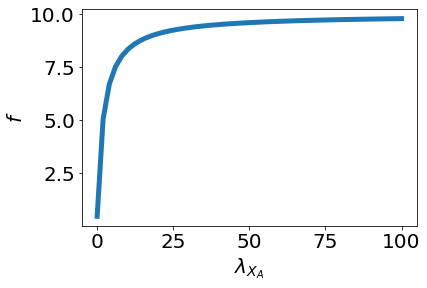

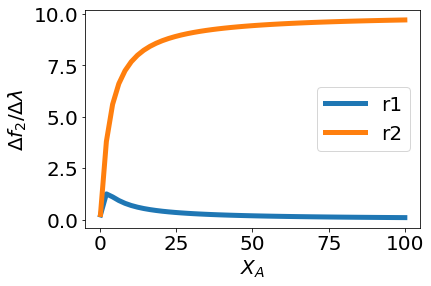

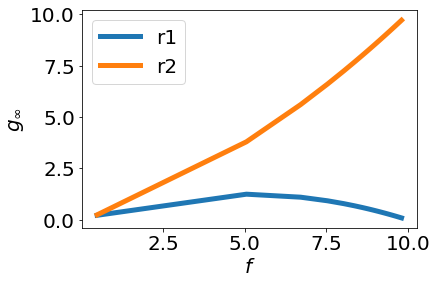

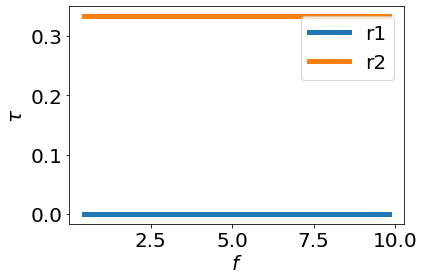

In [101]:
QuasiSteadyState(Inp=['sr1','sr2'],points=50)

### Initial condition sensitivity.


Compatibility error = 0.0


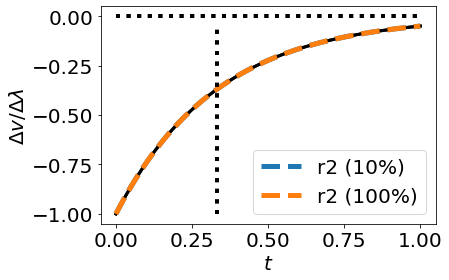

In [102]:
## Set up deviation state for full system
n_X = sc['n_X']
sX0 = np.zeros(n_X)
spec = sc['species']
i_C = spec.index('C')
i_E = spec.index('E')
sX0[i_E] = 1
sX0[i_C] = -1

## Test conserved moiety compatability
G_c = sc['G']
error = np.linalg.norm(G_c@sX0)
print('Compatibility error =',error)

## Compare linear and non-linear
inp = 'sr1'
outp = ['r2']
for lam in [1.1,2,]:
    dat,y_lin,t,sys = simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,
                                      sX0=sX0,
                                     parameter=parameter,inp=[inp],outp=outp,lam=lam,t_last=1)
#     print(con.dcgain(sys))
    g = con.dcgain(sys)
#     if Titles:
#         plt.title(f'{inp} (g = {g:.3f})')
    plotSensitivity(dat,reactions=outp)
    g=0;plotLines()
Savefig('ECR_IC')

## Example: Modulated Enzyme-catalysed reaction

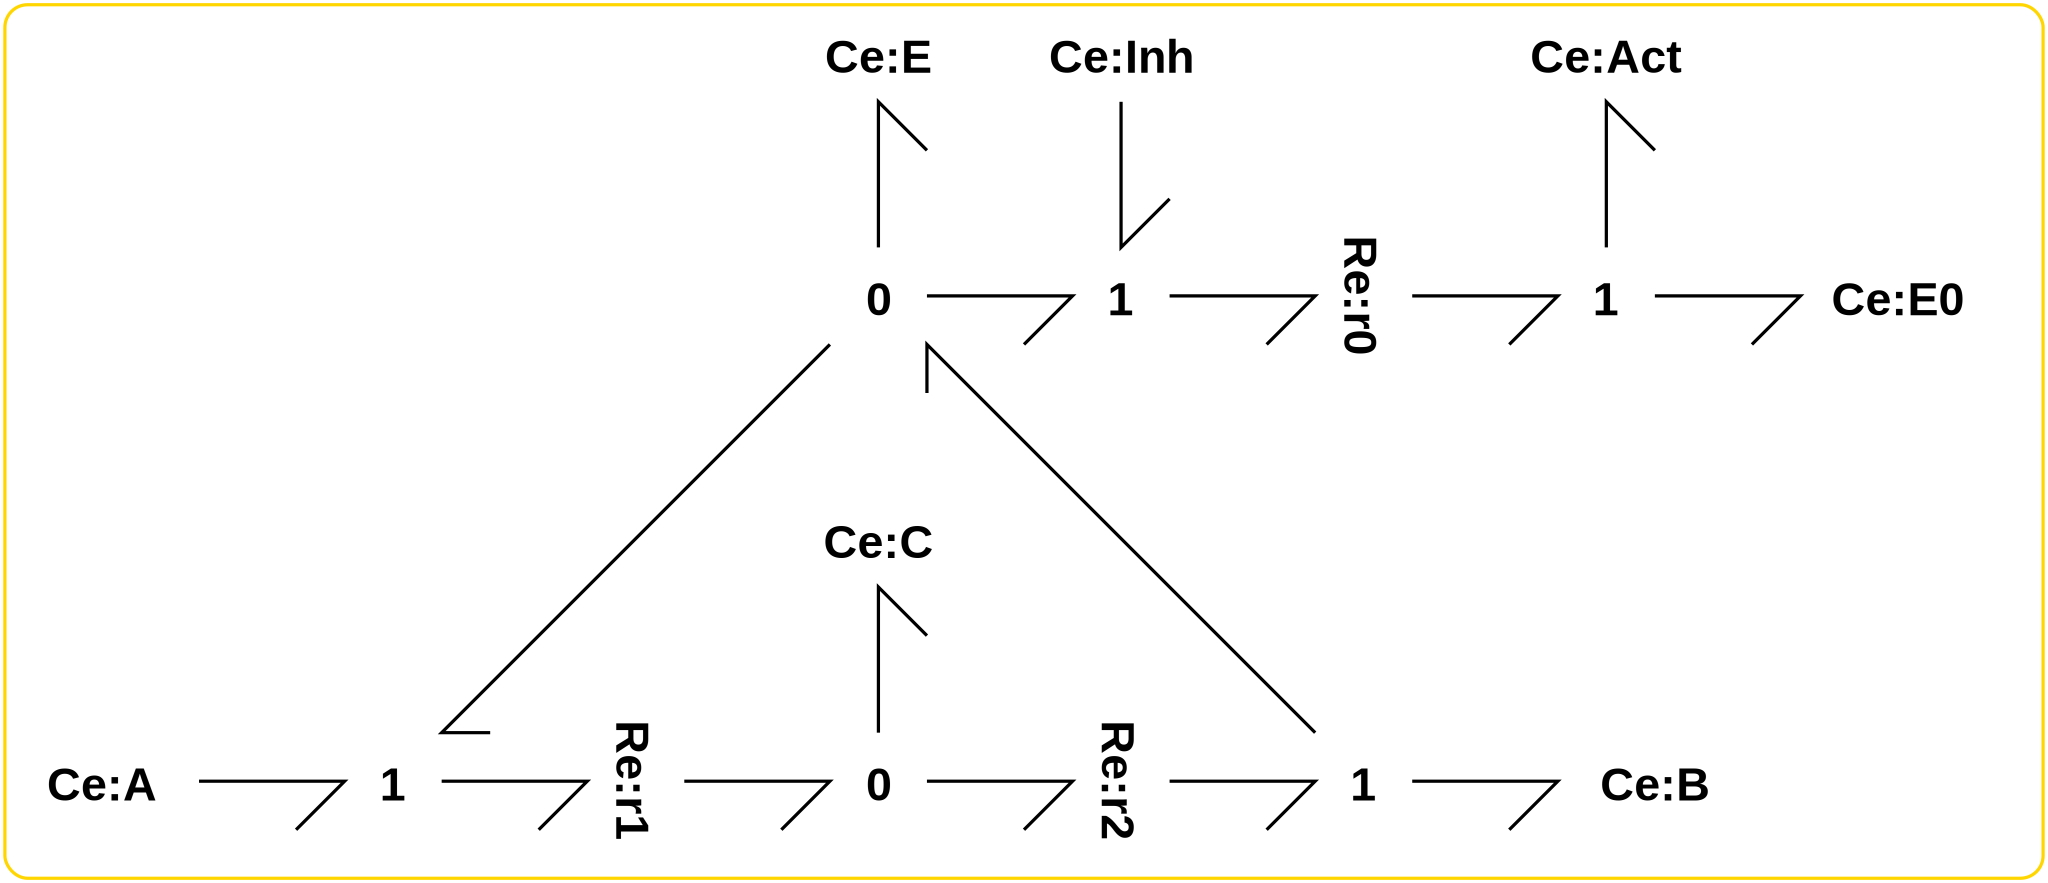

In [103]:
sbg.model('ecr_abg.svg')
import ecr_abg
imp.reload(ecr_abg)
disp.SVG('ecr_abg.svg')

In [104]:
## Stoichiometry
s0 = st.stoich(ecr_abg.model(),quiet=quiet)
species = s0['species']
n_X = s0['n_X']
n_V = s0['n_V']

In [105]:
## Initial states (for sensitivity system)
# e0 = 10
XX0 = {}
# XX0['A'] = 1
XX0['E'] = e0/3
XX0['E0'] = e0/3
XX0['C'] = e0/3
XX0['Inh'] = 1
X0 = np.ones(2*n_X+n_V)

for spec in XX0:
    X0[species.index(spec)] = XX0[spec]

In [106]:
## Parameters
parameter = {}
parameter['K_A'] = 1
parameter['K_B'] = K_B
# parameter['K_F'] = 1
# parameter['K_G'] = 1
parameter['kappa_r0'] = 1
parameter['kappa_r1'] = kappa_1
parameter['kappa_r2'] = 1
parameter['K_E0'] = 1
print(parameter)


{'K_A': 1, 'K_B': 0.001, 'kappa_r0': 1, 'kappa_r1': 1, 'kappa_r2': 1, 'K_E0': 1}


In [107]:
## Chemostats
chemostats = ['A','B','Act','Inh']

['A', 'B', 'C', 'E', 'sA', 'sB', 'sC', 'sE', 'sr1', 'sr2']
Steady-state finder error: 1.66e-15
X_ss = [1.    1.    1.    2.002 3.999 3.999 1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.   ]
V_ss = [-8.882e-16  1.998e+00  1.998e+00]
<LinearIOSystem>: sys[315]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (2): ['x[0]', 'x[1]']

A = [[-2.     1.001]
     [ 1.    -3.001]]

B = [[ 3.999]
     [-3.999]]

C = [[-1.     1.   ]
     [ 1.    -0.001]]

D = [[3.999]
     [0.   ]]

g = 1.60, tau = 0.32


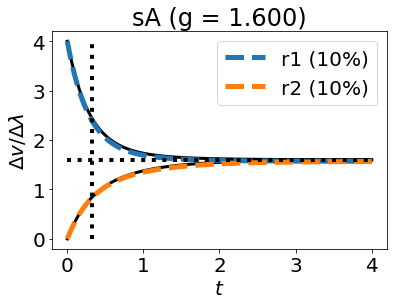

<LinearIOSystem>: sys[317]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (2): ['x[0]', 'x[1]']

A = [[-2.     1.001]
     [ 1.    -3.001]]

B = [[ 1.998]
     [-1.998]]

C = [[-1.     1.   ]
     [ 1.    -0.001]]

D = [[1.998]
     [0.   ]]

g = 0.80, tau = 0.32


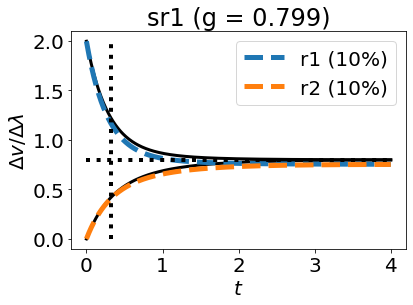

<LinearIOSystem>: sys[319]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (2): ['x[0]', 'x[1]']

A = [[-2.     1.001]
     [ 1.    -3.001]]

B = [[-1.998]
     [ 1.998]]

C = [[-1.     1.   ]
     [ 1.    -0.001]]

D = [[0.   ]
     [1.998]]

g = 1.20, tau = 0.32


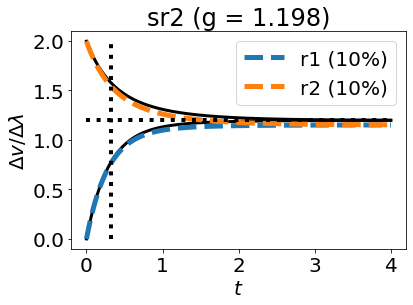

<LinearIOSystem>: sys[321]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (2): ['x[0]', 'x[1]']

A = [[-2.     1.001]
     [ 1.    -3.001]]

B = [[0.   ]
     [3.999]]

C = [[-1.     1.   ]
     [ 1.    -0.001]]

D = [[0.]
     [0.]]

g = 0.80, tau = 0.40


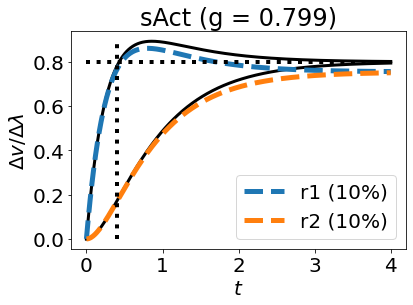

<LinearIOSystem>: sys[323]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (2): ['x[0]', 'x[1]']

A = [[-2.     1.001]
     [ 1.    -3.001]]

B = [[ 0.   ]
     [-3.999]]

C = [[-1.     1.   ]
     [ 1.    -0.001]]

D = [[0.]
     [0.]]

g = -0.80, tau = 0.40


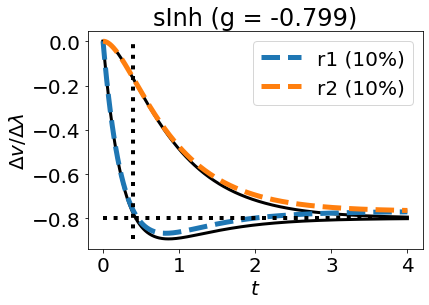

In [108]:
imp.reload(st)
dcgain = {}
syss = {}
print(s['species'])
s,sc,sf,Sys,X_ss,V_ss,dX_ss = stoichSensitivity(ecr_abg.model(),parameter=parameter,chemostats=chemostats,X0=X0)
lam = 1.1
outp = ['r1','r2']
Inp = ['sA','sr1','sr2','sAct','sInh']
#Inp = ['sAct','sInh','sA','sB']
t_last = 4
for inp in Inp:
    dat,y_lin,t,sys = simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,
                                      parameter=parameter,inp=[inp],outp=outp,lam=lam,t_last=t_last)
    syss[inp] = sys
    print(sys)
#     g = con.dcgain(sys)[0][0]
    g,tau = tfProps(sys)
    dcgain[inp] = g
    print(f'g = {g:0.2f}, tau = {tau:0.2f}')
    if Titles:
        plt.title(f'{inp} (g = {g:.3f})')
    plotSensitivity(dat,reactions=outp)
    plotLines()
#     plt.hlines(g,min(t),max(t),color='black',ls='dashed')
    Savefig('ecr_'+inp)
    plt.show()

### Vary $\lambda$

In [109]:
tau


0.39992001599680055

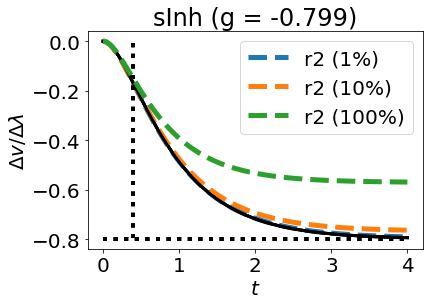

In [110]:
inp = 'sInh'
outp = ['r2']
for lam in [1.01,1.1,2]:
    dat,y_lin,t,sys = simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,
                                      parameter=parameter,inp=[inp],outp=outp,lam=lam,t_last=t_last)
#     print(con.dcgain(sys))
    g = con.dcgain(sys)
    if Titles:
        plt.title(f'{inp} (g = {g:.3f})')
    plotSensitivity(dat,reactions=outp)
    plotLines()
Savefig('ecr_lambda')

### Show system transfer functions

In [111]:
## Show system TFs
con.tf(syss['sAct'])

TransferFunction([[array([3.999, 3.995])], [array([-0.004,  3.995])]], [[array([1.   , 5.001, 5.001])], [array([1.   , 5.001, 5.001])]])

In [112]:
con.tf(syss['sInh'])

TransferFunction([[array([-3.999, -3.995])], [array([ 0.004, -3.995])]], [[array([1.   , 5.001, 5.001])], [array([1.   , 5.001, 5.001])]])

###  Test model reduction 

g = -0.80, tau = 0.40
g = -1.16, tau = 0.40


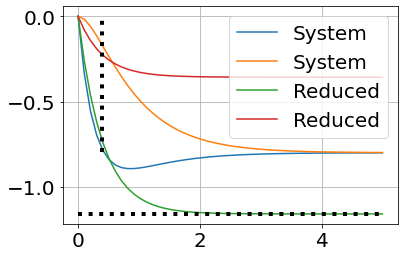

In [113]:
## Test model reduction - truncate
method = 'truncate'
sys = syss['sInh']
g,tau = tfProps(sys)
print(f'g = {g:.2f}, tau = {tau:.2f}')
sys1 = con.balred(sys,orders=1,method=method)
# print(con.dcgain(sys))
# print(con.dcgain(sys1))
con.tf(sys1)
g,tau = tfProps(sys1)
print(f'g = {g:.2f}, tau = {tau:.2f}')

t = np.linspace(0,5)
step = con.step_response(sys,T=t)
step1 = con.step_response(sys1,T=t)
plt.plot(t,step.outputs[:,0,:].T,label='System')
plt.plot(t,step1.outputs[:,0,:].T,label='Reduced')
plt.legend()
plt.grid()
plotLines()

g = -0.80, tau = 0.40
g = -0.80, tau = 0.40


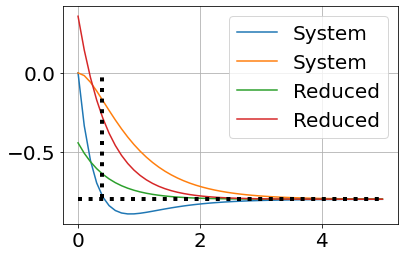

In [114]:
## Test model reduction - matchdc
method = 'matchdc'
sys = syss['sInh']
g,tau = tfProps(sys)
print(f'g = {g:.2f}, tau = {tau:.2f}')
sys1 = con.balred(sys,orders=1,method=method)
# print(con.dcgain(sys))
# print(con.dcgain(sys1))
con.tf(sys1)
g,tau = tfProps(sys1)
print(f'g = {g:.2f}, tau = {tau:.2f}')

t = np.linspace(0,5)
step = con.step_response(sys,T=t)
step1 = con.step_response(sys1,T=t)
plt.plot(t,step.outputs[:,0,:].T,label='System')
plt.plot(t,step1.outputs[:,0,:].T,label='Reduced')
plt.legend()
plt.grid()
plotLines()

### Simulate over flow range - quasi steady-state. Vary Activation and Inhibition.

{'A': '(0.1 + 0.0001*(t-1000.0)*(1*(t>1000.0)))'}
Steady-state finder error: 7.85e-17


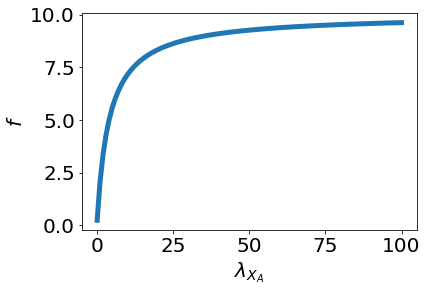

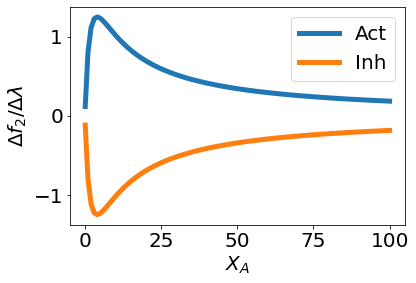

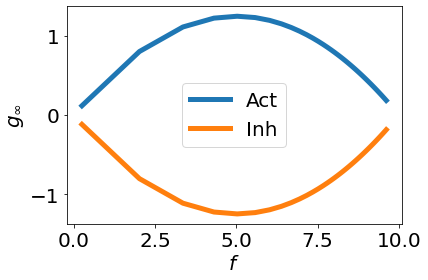

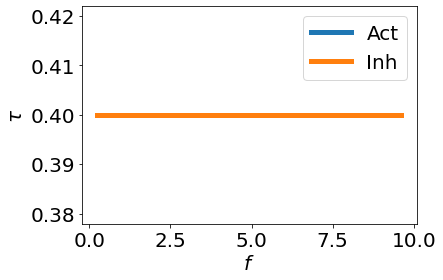

In [115]:
QuasiSteadyState(Inp=['sAct','sInh'],points=100)


### Simulate over flow range - quasi steady-state. Vary Re components

{'A': '(0.1 + 0.0001*(t-1000.0)*(1*(t>1000.0)))'}
Steady-state finder error: 7.85e-17


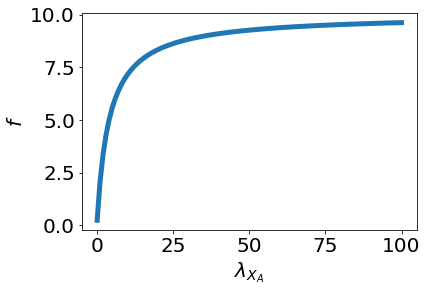

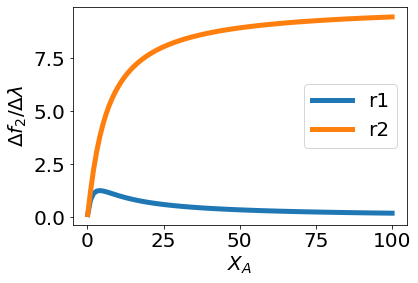

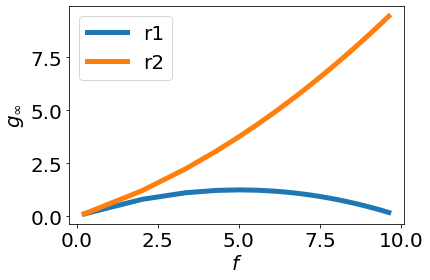

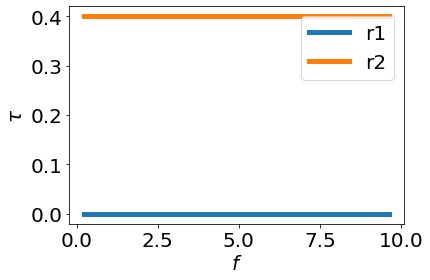

In [116]:
QuasiSteadyState(Inp=['sr1','sr2'],points=100)


### Simulate over flow range - quasi steady-state. Vary substrate concentration.

{'A': '(0.1 + 0.0001*(t-1000.0)*(1*(t>1000.0)))'}
Steady-state finder error: 7.85e-17


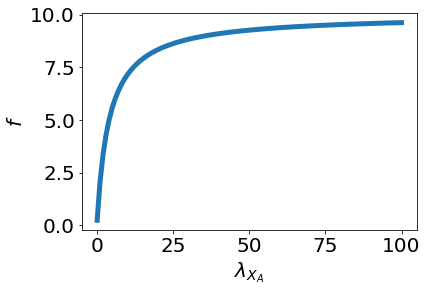

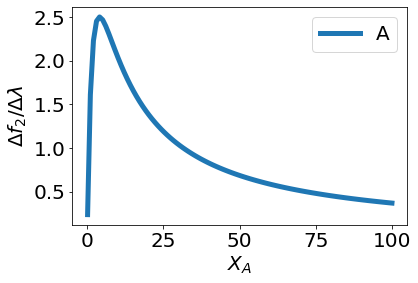

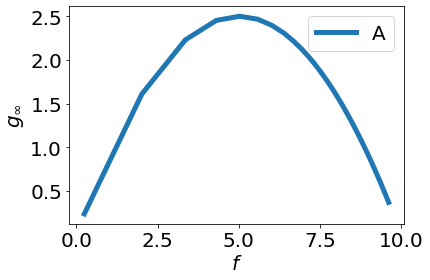

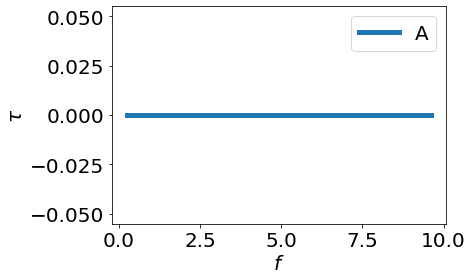

In [117]:
QuasiSteadyState(Inp=['sA'],points=100)


### Sloppy parameters

ecr

 t_f = 4.00
H:
\sqrt\sigma_1 &= 2 & V_1\Lambda &= + 0.837 \lambda_{r2} + 0.548 \lambda_{r1}
\sqrt\sigma_2 &= 0.44 & V_2\Lambda &= + 0.837 \lambda_{r1} - 0.548 \lambda_{r2}
H_ss:
\sqrt\sigma_1 &= 2 & V_1\Lambda &= + 0.832 \lambda_{r2} + 0.555 \lambda_{r1}
\sqrt\sigma_2 &= 1e-06 & V_2\Lambda &= + 0.832 \lambda_{r1} - 0.555 \lambda_{r2}
Direct:
\sqrt\sigma_1 &= 1.4 & V_1\Lambda &= + 0.832 \lambda_{r2} + 0.555 \lambda_{r1}


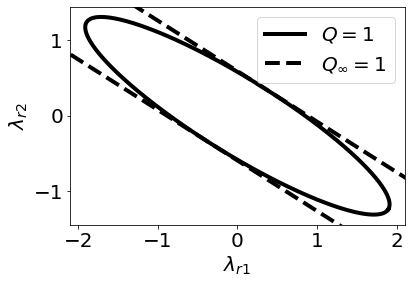

ecr

 t_f = 4.00
H:
\sqrt\sigma_1 &= 1.5 & V_1\Lambda &= + 0.966 \lambda_{E} + 0.257 \lambda_{C}
\sqrt\sigma_2 &= 0.79 & V_2\Lambda &= + 0.966 \lambda_{C} - 0.257 \lambda_{E}
H_ss:
\sqrt\sigma_1 &= 1.3 & V_1\Lambda &= + 0.894 \lambda_{E} + 0.448 \lambda_{C}
\sqrt\sigma_2 &= 1e-06 & V_2\Lambda &= + 0.894 \lambda_{C} - 0.448 \lambda_{E}
Direct:
\sqrt\sigma_1 &= 0.89 & V_1\Lambda &= + 0.894 \lambda_{E} + 0.448 \lambda_{C}


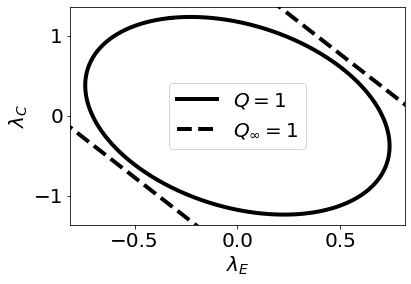

ecr

 t_f = 4.00
H:
\sqrt\sigma_1 &= 2.4 & V_1\Lambda &= + 1.000 \lambda_{A} - 0.001 \lambda_{B}
\sqrt\sigma_2 &= 0.0015 & V_2\Lambda &= + 1.000 \lambda_{B} + 0.001 \lambda_{A}
H_ss:
\sqrt\sigma_1 &= 2.3 & V_1\Lambda &= + 1.000 \lambda_{A} - 0.001 \lambda_{B}
\sqrt\sigma_2 &= 1e-06 & V_2\Lambda &= + 1.000 \lambda_{B} + 0.001 \lambda_{A}
Direct:
\sqrt\sigma_1 &= 1.6 & V_1\Lambda &= + 1.000 \lambda_{A}


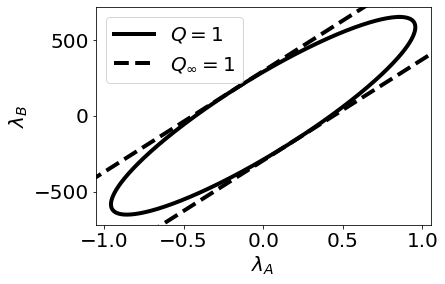

ecr

 t_f = 100.00
H:
\sqrt\sigma_1 &= 2 & V_1\Lambda &= + 0.832 \lambda_{r2} + 0.555 \lambda_{r1}
\sqrt\sigma_2 &= 0.2 & V_2\Lambda &= + 0.832 \lambda_{r1} - 0.555 \lambda_{r2}
H_ss:
\sqrt\sigma_1 &= 2 & V_1\Lambda &= + 0.832 \lambda_{r2} + 0.555 \lambda_{r1}
\sqrt\sigma_2 &= 1e-06 & V_2\Lambda &= + 0.832 \lambda_{r1} - 0.555 \lambda_{r2}
Direct:
\sqrt\sigma_1 &= 1.4 & V_1\Lambda &= + 0.832 \lambda_{r2} + 0.555 \lambda_{r1}


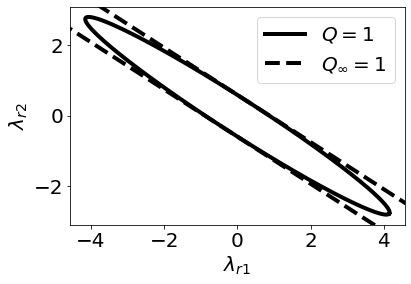

ecr

 t_f = 100.00
H:
\sqrt\sigma_1 &= 1.3 & V_1\Lambda &= + 0.917 \lambda_{E} + 0.400 \lambda_{C}
\sqrt\sigma_2 &= 0.4 & V_2\Lambda &= + 0.917 \lambda_{C} - 0.400 \lambda_{E}
H_ss:
\sqrt\sigma_1 &= 1.3 & V_1\Lambda &= + 0.894 \lambda_{E} + 0.448 \lambda_{C}
\sqrt\sigma_2 &= 1e-06 & V_2\Lambda &= + 0.894 \lambda_{C} - 0.448 \lambda_{E}
Direct:
\sqrt\sigma_1 &= 0.89 & V_1\Lambda &= + 0.894 \lambda_{E} + 0.448 \lambda_{C}


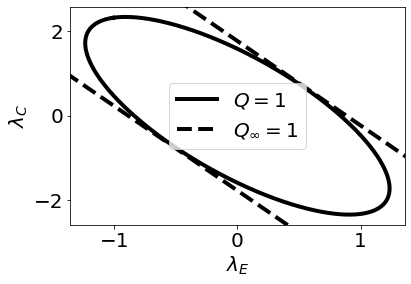

ecr

 t_f = 100.00
H:
\sqrt\sigma_1 &= 2.3 & V_1\Lambda &= + 1.000 \lambda_{A} - 0.001 \lambda_{B}
\sqrt\sigma_2 &= 0.00072 & V_2\Lambda &= + 1.000 \lambda_{B} + 0.001 \lambda_{A}
H_ss:
\sqrt\sigma_1 &= 2.3 & V_1\Lambda &= + 1.000 \lambda_{A} - 0.001 \lambda_{B}
\sqrt\sigma_2 &= 1e-06 & V_2\Lambda &= + 1.000 \lambda_{B} + 0.001 \lambda_{A}
Direct:
\sqrt\sigma_1 &= 1.6 & V_1\Lambda &= + 1.000 \lambda_{A}


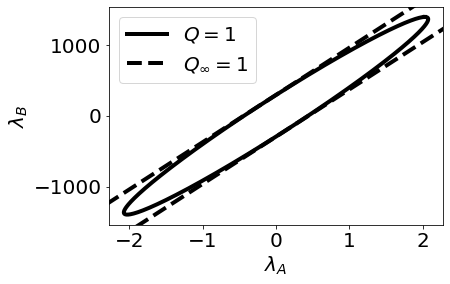

In [118]:
imp.reload(slp)

for t_last in [4,1e2]:
    if t_last==0:
        t = None
    else:
        t = np.linspace(0,t_last,100)

    sloppyBoth(Sys,['sr1','sr2'],['r1','r2'],t=t)
    sloppyBoth(Sys,['sE','sC'],['r1','r2'],t=t)
    sloppyBoth(Sys,['sA','sB'],['r1','r2'],t=t)
    

In [119]:
imp.reload(slp)
Outp = ['r1']
Inp_reac = ['sr1','sr2']
def PrintSloppy(Inp,Outp,GainOnly=True,tf=None):
    blurb = '\n*********\n'
    
    if tf is None:
        t = None
    else:
        t = np.linspace(0,tf)
        
    for outp in Outp:
        print(blurb,outp,blurb)
        sys = extractSubsystem(Sys,sc,sf,Inp,[outp])
#         print(con.dcgain(sys))
        gain = con.dcgain(sys)[0]
        norm = np.sum(gain*gain)
        ngain = gain/np.sqrt(norm)
#         print(norm,gain/np.sqrt(norm))
        H,eig,eigv,t = slp.Sloppy(sys,GainOnly=GainOnly,small=1e-10,t=tf)
        slp.SloppyPrint(eig,eigv,Inp,min_eig=0.0,min_eigv=0.05,max_eigs=2)
        if GainOnly:
            print('Direct')
            slp.SloppyPrint([norm],np.array([ngain]).T,Inp,min_eig=0.0,min_eigv=0.05,max_eigs=2)
#         print(eigv[:,0])
#         print(ngain)

## Reactions
for tf in [None,1e2]:
    for GainOnly in [True,False]:
        print('\nGainOnly =',GainOnly,'; tf =',tf)
        PrintSloppy(Inp_reac,Outp,GainOnly=GainOnly,tf=tf)



GainOnly = True ; tf = None

*********
 r1 
*********

\sqrt\sigma_1 &= 1.4 & V_1\Lambda &= + 0.832 \lambda_{r2} + 0.555 \lambda_{r1}
\sqrt\sigma_2 &= 1e-05 & V_2\Lambda &= + 0.832 \lambda_{r1} - 0.555 \lambda_{r2}
Direct
\sqrt\sigma_1 &= 1.4 & V_1\Lambda &= + 0.832 \lambda_{r2} + 0.555 \lambda_{r1}

GainOnly = False ; tf = None

*********
 r1 
*********

\sqrt\sigma_1 &= 1.4 & V_1\Lambda &= + 0.787 \lambda_{r2} + 0.617 \lambda_{r1}
\sqrt\sigma_2 &= 0.29 & V_2\Lambda &= + 0.787 \lambda_{r1} - 0.617 \lambda_{r2}

GainOnly = True ; tf = 100.0

*********
 r1 
*********

\sqrt\sigma_1 &= 1.4 & V_1\Lambda &= + 0.832 \lambda_{r2} + 0.555 \lambda_{r1}
\sqrt\sigma_2 &= 1e-05 & V_2\Lambda &= + 0.832 \lambda_{r1} - 0.555 \lambda_{r2}
Direct
\sqrt\sigma_1 &= 1.4 & V_1\Lambda &= + 0.832 \lambda_{r2} + 0.555 \lambda_{r1}

GainOnly = False ; tf = 100.0

*********
 r1 
*********

\sqrt\sigma_1 &= 1.4 & V_1\Lambda &= + 0.830 \lambda_{r2} + 0.558 \lambda_{r1}
\sqrt\sigma_2 &= 0.069 & V_2\Lambda &= + 0

### Initial condition sensitivity.


Compatibility error = 0.0


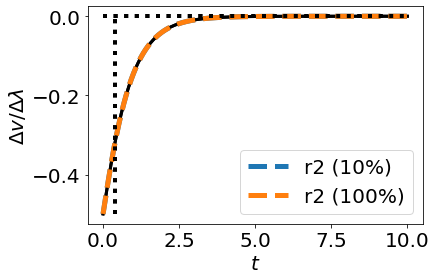

In [120]:
## Set up deviation state for full system
n_X = sc['n_X']
sX0 = np.zeros(n_X)
spec = sc['species']
i_C = spec.index('C')
i_E = spec.index('E')
i_E0 = spec.index('E0')

sX0[i_E0] = 1
sX0[i_E] = -0.5
sX0[i_C] = -0.5

## Test conserved moiety compatability
G_c = sc['G']
error = np.linalg.norm(G_c@sX0)
print('Compatibility error =',error)

## Compare linear and non-linear
inp = 'sr1'
outp = ['r2']
for lam in [1.1,2,]:
    dat,y_lin,t,sys = simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,
                                      sX0=sX0,
                                     parameter=parameter,inp=[inp],outp=outp,lam=lam,t_last=10)
#     print(con.dcgain(sys))
    g = con.dcgain(sys)
#     if Titles:
#         plt.title(f'{inp} (g = {g:.3f})')
    plotSensitivity(dat,reactions=outp)
    g=0;plotLines()
Savefig('ecr_IC')